# Stats Workflow

**Cara Piske, Graduate Program of Hydrologic Sciences, 2022; Advisor: Dr. Adrian Harpold**<br>
This code processes lidar-derived rasters to evaluate the difference between snow properties (SWE) in under vs. open canopy classifications. <br>
Lidar data were provided by the Airborne Snow Observatory (ASO), the National Center for Airborne Laser Mapping (NCALM), and Watershed Sciences Inc. (WSI). <br>

See: Varhola, A., Coops, N. C., Weiler, M., & Moore, R. D. (2010). Forest canopy effects on snow accumulation and ablation: An integrative review of empirical results. In Journal of Hydrology (Vol. 392, Issues 3–4, pp. 219–233). Elsevier. https://doi.org/10.1016/j.jhydrol.2010.08.009 <br>
and<br>
Kostadinov, T. S., Schumer, R., Hausner, M., Bormann, K. J., Gaffney, R., McGwire, K., Painter, T. H., Tyler, S., & Harpold, A. A. (2019). Watershed-scale mapping of fractional snow cover under conifer forest canopy using lidar. Remote Sensing of Environment, 222, 34–49. https://doi.org/10.1016/j.rse.2018.11.037

In [1]:

# import necessary packages 
from osgeo import gdal, ogr, osr
import csv
import os
import subprocess
import sys
import pdal
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import time
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import subprocess
import statsmodels.api as sm

# competing paths on our PC 
gdal_merge = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_merge.py')
gdal_calc = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_calc.py')
gdal_warp = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_warp.py')
gdal_polygonize = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_polygonize.py')
gdal_proximity = os.path.join('C:\\','Users','cpiske','.conda','envs','lidar','Lib','site-packages','osgeo_utils','gdal_proximity.py')

In [2]:
#make sure we're in the right working directory
os.chdir('/')
print(os.getcwd())

G:\


## Load Data

In [3]:
# input - path = str. i.e. 'SCB/kane_veg_metrics/departure/14_withholes/departure_wh_clip2dem.tif'
# input - nd_value = int. no data value
# output - raster_arr = 1D array of raster values (maintaining columns)
def raster_to_array(path, nd_value):
    raster = gdal.Open(path) # open the file 
    raster_arr = raster.GetRasterBand(1).ReadAsArray() #read the first raster band (in this case we know we are only working with single bands) and read to a 2D array
    if raster_arr.dtype == 'int32':
        raster_arr = raster_arr.astype(float)
    raster_arr[raster_arr == nd_value] = np.nan # where the raster is equal to the provided no data value, set values to Nan
    raster_arr_flat = raster_arr.flatten() # flatten the array (row-wise)
    raster = None
    return raster_arr_flat

## Flight Info
Extract metadata and statistics on each flight

In [268]:
# determine average number of points
# this is actually more complicated than it should be because of our overlapping tiles, so
# this will just be a broad estimate
input_tif = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/counts/NCALM_SCB_20220321_counts.tif'
counts_arr = raster_to_array(input_tif, -9999)

In [271]:
counts_arr[counts_arr>200] = np.nan
#counts_arr[counts_arr<200] = np.nan
print(np.nanpercentile(counts_arr, 10))
print(np.nanpercentile(counts_arr, 50))
print(np.nanpercentile(counts_arr, 90))
print(np.nanmean(counts_arr))

0.0
28.0
87.0
35.440211881943895


# Vegetation and Terrain

### Load Data- Create DataFrame

In [8]:
# terrain variables
DEM_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE_30m.tif', -9999)
nness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_nness_30m.tif', -9999)

In [9]:
# terrain variables
DEM_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_BE_30m.tif', -9999)
nness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/DEM/SCB/NCALM_2014_nness_30m.tif', -9999)
# vegetation variables
fVEG_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/fVeg/NCALM_SCB_2014_fVEG_30m.tif', -9999)
canopy_density_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/fVeg/NCALM_SCB_2014_canopy_density_30m.tif', -9999)
openness_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/NCALM_SCB_2014_DNC_avgTAOheight_30m.tif', -9999)
LAI_arr = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/NCALM_SCB_2014_LAI_prime_30m.tif', -9999)
TAO_den = raster_to_array('SCB/Sagehen_lidar/NCALM/NCALM_SCB_2014/canopy_metrics/veg_structure/TAO/NCALM_SCB_2014_TAO_density_30m.tif',-9999)

#### Define bins

In [14]:
terain_veg_dict = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "openness": np.log(openness_arr),
    "canopy_den":canopy_density_arr,
    'LAI':LAI_arr,
    "TAO_den": TAO_den
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.5,-0.25,0,0.25,0.5])
fVEG_bins_set = ([0,0.2,0.4,0.6,0.8,1.0]) # ([0,0.25,0.5, 0.75, 1.0])
#opennes_bins = ([0,0.5,1,1.5, 2, 2.5, 3])
opennes_bins = ([-5,-2,-1,0,1,2,5])
canopy_den_bins = ([0,0.2,0.4,0.6,0.8])
LAI_bins = ([0, 0.1, 0.2, 0.3, 0.4, 0.5])
TAO_bins = ([0, 0.02, 0.04, 0.06, 0.08])

In [15]:
terain_veg_dict['nness_bins'] = pd.cut(terain_veg_dict['nness'], bins=nness_bins_set, right = False,include_lowest= True)
terain_veg_dict['elev_bins'] = pd.cut(terain_veg_dict['elev'], bins=elev_bins_set, right = False,include_lowest= True)
terain_veg_dict['fVeg_bins'] = pd.cut(terain_veg_dict['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
terain_veg_dict['openness_bins'] = pd.cut(terain_veg_dict['openness'], bins=opennes_bins, right = False,include_lowest= True)
terain_veg_dict['canopy_den_bins'] = pd.cut(terain_veg_dict['canopy_den'], bins=canopy_den_bins, right = False,include_lowest= True)
terain_veg_dict['LAI_bins'] = pd.cut(terain_veg_dict['LAI'], bins=LAI_bins, right = False,include_lowest= True)
terain_veg_dict['TAO_bins'] = pd.cut(terain_veg_dict['TAO_den'], bins=TAO_bins, right = False,include_lowest= True)

#### Plot

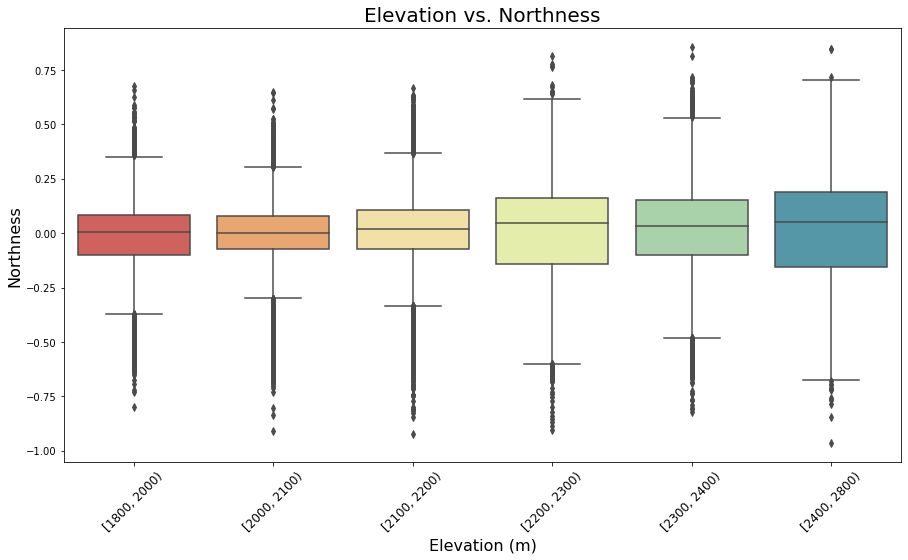

In [985]:
fVEG_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis
# we want a scatterplot
# specify figure axis (ax=axes)
# data = dataframe name, x = dataframe column name, y = dataframe column name
# hue = color values by variable, marker = specify style, s = size of marker, palette = color palette

sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="nness", palette = 'Spectral') #, hue = 'nness_bins'
axes.set_title('Elevation vs. Northness', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('Northness', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

#fVEG_box.savefig('SCB/stats/figures/nness_elev_GapSize.png',transparent=True,bbox_inches='tight',dpi=300)

**Elevation, Nness, Slope**

In [ ]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(1, 3, figsize =(15,4));
axs[0].hist(terain_veg_dict['elev']); axs[0].set_xlabel('Elevation (m)'); axs[0].set_ylabel('Frequency')
axs[1].hist(terain_veg_dict['slope']); axs[1].set_xlabel('Slope (deg)')
axs[2].hist(terain_veg_dict['nness']); axs[2].set_xlabel('Northness')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [866]:
terain_veg_dict.columns

Index(['elev', 'nness', 'fVeg', 'openness', 'canopy_den', 'LAI', 'TAO_den',
       'nness_bins', 'elev_bins', 'fVeg_bins', 'openness_bins',
       'canopy_den_bins', 'LAI_bins', 'TAO_bins'],
      dtype='object')

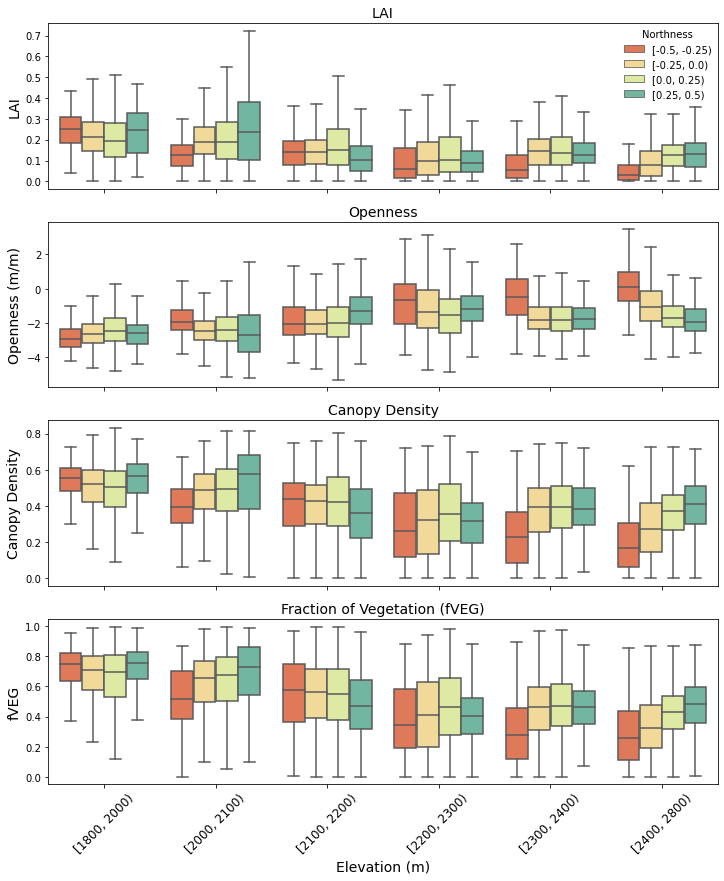

In [1056]:
elev_nness_fveg_fig, axes = plt.subplots(4,1,figsize=(12, 14), sharey=False) # create a figure axis
#plt.tight_layout(pad = 1, h_pad = 1)

sns.boxplot(ax=axes[0], data=terain_veg_dict, x='elev_bins', y="LAI", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('LAI', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('LAI', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend(loc='upper right', borderaxespad=0.2, title= 'Northness', fontsize=10, frameon=False)
#axes[0].text(-0.40, 0.7,"a", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[1], data=terain_veg_dict, x='elev_bins', y="openness", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Openness', fontsize = 14); axes[1].set_xlabel(''); axes[1].set_ylabel('Openness (m/m)', fontsize = 14)
axes[1].set_xticklabels([])
#axes[1].set_yscale("log")
axes[1].legend([],frameon=False)#(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[1].text(-0.40, 0.7,"b", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[2], data=terain_veg_dict, x='elev_bins', y="canopy_den", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[2].set_title('Canopy Density', fontsize = 14); axes[2].set_xlabel(''); axes[2].set_ylabel('Canopy Density', fontsize = 14)
axes[2].set_xticklabels([])
axes[2].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[2].text(-0.40, 0.7,"c", ha="left", va="top", size='medium', color='black', weight='normal')

sns.boxplot(ax=axes[3], data=terain_veg_dict, x='elev_bins', y="fVeg", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[3].set_title('Fraction of Vegetation (fVEG)', fontsize = 14); axes[3].set_xlabel('Elevation (m)', fontsize = 14); axes[3].set_ylabel('fVEG', fontsize = 14)
axes[3].set_xticklabels(axes[3].get_xticklabels(),rotation = 45, fontsize = 12)
axes[3].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.8), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[3].text(-0.40, 0.7,"d", ha="left", va="top", size='medium', color='black', weight='normal')

elev_nness_fveg_fig.savefig('SCB/stats/figures/terrain_veg/elev_nness_veg.png',transparent=True,bbox_inches='tight',dpi=300)

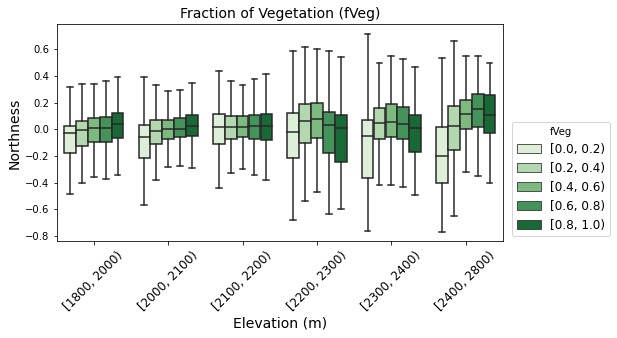

In [319]:
elev_nness_fveg_fig, axes = plt.subplots(1,1,figsize=(8, 4), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=terain_veg_dict, x='elev_bins', y="nness", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Fraction of Vegetation (fVeg)', fontsize = 14); axes.set_xlabel('Elevation (m)', fontsize = 14); axes.set_ylabel('Northness', fontsize = 14)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12)
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'fVeg', fontsize=12)
#elev_nness_fveg_fig.savefig('SCB/stats/figures/elev_nness_fVeg.png',transparent=True,bbox_inches='tight',dpi=300)

terrain vs fveg

In [ ]:
nness_fveg_box, axes = plt.subplots(2,1,figsize=(10, 5), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=terain_veg_dict, x='nness_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('nness vs. fVeg'); #axes.set(xlabel = 'Vegetation Departure',ylabel = 'Northness'); axes.set_xticklabels(axes.get_xticklabels(),rotation = 45);
#dep_nness_box.savefig('lidar_processing/python_scripts/snow_departure_project/figures/dep_nness_box.png')
sns.boxplot(ax=axes[1], data=terain_veg_dict, x='elev_bins', y="fVeg", palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('elev vs. fVeg');

# Delta Change in Snowpack Properties
We'll start off using only our best estimate of snowpack accumulation, which is the earliest flight available from each year. <br>

## Accumulation
Calculated as the difference between open and tall snowpack

### Load Data

In [4]:
# Start with the ASO flight
ASO_0326_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered_30m.tif'
ASO_0326_tall = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_tall_30m.tif'
ASO_0326_all = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_30m.tif'

ASO_delta_acc_raw = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation_raw.tif'
ASO_delta_acc_abs = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation_abs.tif'
ASO_delta_acc = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation.tif'
ASO_delta_acc_tall = 'SCB/stats/delta_accumulation_rasters/ASO_20160326_deltaAccumulation_tallRef.tif'


NCALM_2008_open = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_open_buffered_30m.tif'
NCALM_2008_tall = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_tall_30m.tif'
NCALM_2008_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20080210/SWE/NCALM_SCB_20080210_SWE_30m.tif'
NCALM_delta_acc = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation.tif'
NCALM_delta_acc_raw = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation_raw.tif'
NCALM_delta_acc_abs = 'SCB/stats/delta_accumulation_rasters/NCALM_20080210_deltaAccumulation_abs.tif'

# Start with the ASO flight
NCALM_2022_open = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_open_buffered_30m.tif'
NCALM_2022_tall = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_tall_30m.tif'
NCALM_2022_all = 'SCB/Sagehen_lidar/NCALM/NCALM_SCB_20220321/SWE/NCALM_SCB_20220321_SWE_30m.tif'
NCALM_delta_acc_2022 = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation.tif'
NCALM_delta_acc_raw_2022 = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_raw.tif'
NCALM_delta_acc_abs_2022 = 'SCB/stats/delta_accumulation_rasters/NCALM_20220321_deltaAccumulation_abs.tif'

### Calculate Accumulation

In [1024]:
# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2008_open,'-B',NCALM_2008_all,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc_raw, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_2008_open,'-B',NCALM_2008_all,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc_abs, '--calc="(B-A)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)


# delta_accumulation_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0326_all,
#  '--outfile', ASO_delta_acc_raw, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0326_all,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_acc_abs, '--calc="(B-A)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)


In [1025]:
# delta_accumulation_cmd = ['python',gdal_calc, '-A', NCALM_delta_acc_raw,'--NoDataValue','-9999',
#  '--outfile', NCALM_delta_acc, '--calc="A*(A<100)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

# delta_accumulation_cmd = ['python',gdal_calc, '-A', ASO_delta_acc_raw,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_acc, '--calc="A*(A<100)"','--overwrite']
# subprocess.run(delta_accumulation_cmd)

### Create Dataframe

In [6]:
# also load in 2022 data for plotting
fVeg_2020 = '/SCB/Sagehen_lidar/NCALM/NCALM_SCB_20201120/canopy_metrics/veg_structure/fVeg/NCALM_SCB_20201120_fVEG_30m.tif'
fVeg_2020_arr = raster_to_array(fVeg_2020, -9999)

NCALM_2022_all_arr = raster_to_array(NCALM_2022_all, -9999)
NCALM_delta_acc_2022_arr = raster_to_array(NCALM_delta_acc_2022, -9999)

# load into array
SWE_0326_arr = raster_to_array(ASO_0326_all, -9999)
ASO_delta_acc_arr = raster_to_array(ASO_delta_acc, -9999)
#ASO_delta_acc_arr_tall = raster_to_array(ASO_delta_acc_tall, -9999)
SWE_0326_open_arr = raster_to_array(ASO_0326_open, -9999)
SWE_0326_tall_arr = raster_to_array(ASO_0326_tall, -9999)


NCALM_delta_acc_arr = raster_to_array(NCALM_delta_acc, -9999)
NCALM_delta_acc_abs_arr = raster_to_array(NCALM_delta_acc_abs, -9999)
NCALM_2008_all_arr = raster_to_array(NCALM_2008_all, -9999)
#NCALM_delta_acc_arr_tall = raster_to_array(NCALM_delta_acc_tall, -9999)
NCALM_2008_open_arr = raster_to_array(NCALM_2008_open, -9999)
NCALM_2008_tall_arr = raster_to_array(NCALM_2008_tall, -9999)


In [43]:
acc_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "fVeg_2020":fVeg_2020_arr,
    "openness": np.log(openness_arr),
    "canopy_den":canopy_density_arr,
    'LAI':LAI_arr,
    "delta_SWE_2008_abs":NCALM_delta_acc_abs_arr,
    "SWE_2008_open": NCALM_2008_open_arr,
    "SWE_2016": SWE_0326_arr,
    "SWE_2008": NCALM_2008_all_arr,
    "SWE_2022": NCALM_2022_all_arr,
    "delta_SWE_2016":ASO_delta_acc_arr,
    "delta_SWE_2008":NCALM_delta_acc_arr,
    "delta_SWE_2022":NCALM_delta_acc_2022_arr,



})
opennes_bins = ([-5,-2.5,0,2.5])
ASO_acc_bins = ([0, 25,50,75, 100, 150, 200])
NCALM_acc_bins = ([0, 25, 50, 75, 100, 125, 150])
ASO_delta_acc_bins = ([-100, -75, -50, -25, 0, 25, 50, 75, 100])
NCALM_delta_acc_bins = ([-40, -20, -10, 0, 20])
NCALM_delta_acc_bins_b = ([-40, -30, -20, -10, 0, 10, 20, 30])

In [44]:
acc_df['elev_bins'] = pd.cut(acc_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
acc_df['fVeg_bins'] = pd.cut(acc_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
acc_df['fVeg_2020_bins'] = pd.cut(acc_df['fVeg_2020'], bins=fVEG_bins_set, right = False,include_lowest= True)
acc_df['openness_bins'] = pd.cut(acc_df['openness'], bins=opennes_bins, right = False,include_lowest= True)

acc_df['nness_bins'] = pd.cut(acc_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)

acc_df['delta_SWE_2016_bins'] = pd.cut(acc_df['delta_SWE_2016'], bins=ASO_delta_acc_bins, right = False,include_lowest= True)
acc_df['delta_SWE_2008_bins'] = pd.cut(acc_df['delta_SWE_2008'], bins=NCALM_delta_acc_bins, right = False,include_lowest= True)

acc_df['SWE_2016_bins'] = pd.cut(acc_df['SWE_2016'], bins=NCALM_acc_bins, right = False,include_lowest= True)
acc_df['SWE_2008_bins'] = pd.cut(acc_df['SWE_2008'], bins=NCALM_acc_bins, right = False,include_lowest= True)


## Ablation

### Load Data

In [1029]:
# set up ablation rasters
ASO_0326_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered.tif'
ASO_0326 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE.tif'
ASO_0326_tall = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_tall.tif'

# create filter representing valid points - where raster >0
ASO_0326_open_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/filtered_GT0/ASO_SCB_20160326_SWE_open_buffered_GT0.tif'
ASO_0326_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/filtered_GT0/ASO_SCB_20160326_SWE_GT0.tif'
ASO_0326_tall_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/filtered_GT0/ASO_SCB_20160326_SWE_tall_GT0.tif'

ASO_0417_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_open_buffered.tif'
ASO_0417 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE.tif'
ASO_0417_tall = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_tall.tif'

ASO_0417_open_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/filtered_GT0/ASO_SCB_20160417_SWE_open_buffered_GT0.tif'
ASO_0417_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/filtered_GT0/ASO_SCB_20160417_SWE_GT0.tif'
ASO_0417_tall_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/filtered_GT0/ASO_SCB_20160417_SWE_tall_GT0.tif'

ASO_0518_open = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_open_buffered.tif'
ASO_0518 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE.tif'
ASO_0518_tall = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_tall.tif'

ASO_0518_open_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/filtered_GT0/ASO_SCB_20160518_SWE_open_buffered_GT0.tif'
ASO_0518_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/filtered_GT0/ASO_SCB_20160518_SWE_GT0.tif'
ASO_0518_tall_GT0 = 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/filtered_GT0/ASO_SCB_20160518_SWE_tall_GT0.tif'

# crate no accumulation filters - these rasters represent places where earlier-later raster is >0, 
# i.e. no oaccumulation occurred during the target period
MarApr_NoAcc = 'SCB/stats/delta_ablation_rasters/filter/MarApr_GT0.tif'
MarApr_NoAcc_open = 'SCB/stats/delta_ablation_rasters/filter/MarApr_open_GT0.tif'
MarApr_NoAcc_tall = 'SCB/stats/delta_ablation_rasters/filter/MarApr_tall_GT0.tif'

AprMay_NoAcc = 'SCB/stats/delta_ablation_rasters/filter/AprMay_GT0.tif'
AprMay_NoAcc_open = 'SCB/stats/delta_ablation_rasters/filter/AprMay_open_GT0.tif'
AprMay_NoAcc_tall = 'SCB/stats/delta_ablation_rasters/filter/AprMay_tall_GT0.tif'

In [1030]:
# set up final ablation rasters
ASO_abl_MarApr_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_open.tif'
ASO_abl_MarApr = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr.tif'
ASO_delta_abl_MarApr = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarApr.tif'

ASO_normalized_abl_MarApr = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr.tif'
ASO_normalized_abl_MarApr_open = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_open.tif'
ASO_normalized_abl_MarApr_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_30m.tif'
ASO_normalized_abl_MarApr_open_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_open_30m.tif'
ASO_normalized_abl_MarApr_diff_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_diff_30m.tif'

ASO_abl_MarMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_open.tif'
ASO_abl_MarMay = 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay.tif'
ASO_delta_abl_MarMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_MarMay.tif'

ASO_normalized_abl_MarMay = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarMay.tif'
ASO_normalized_abl_MarMay_open = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarMay_open.tif'

ASO_abl_AprMay_open = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_open.tif'
ASO_abl_AprMay = 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay.tif'
ASO_delta_abl_AprMay = 'SCB/stats/delta_ablation_rasters/ASO_delta_abl_AprMay.tif'

ASO_normalized_abl_AprMay = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay.tif'
ASO_normalized_abl_AprMay_open = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_open.tif'
ASO_normalized_abl_AprMay_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_30m.tif'
ASO_normalized_abl_AprMay_open_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_open_30m.tif'
ASO_normalized_abl_AprMay_diff_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_diff_30m.tif'

### Calculate Ablation Metrics

#### Filter

First we create filtered rasters
We want to filter out<br> 1. pixels where the second date goes to 0 <br>
2. pixels where there has been accumulation <br>
by creating logical rasters with 1 representing pixels we want to keep <br>

We calculate a delta accumulation following the exact Varhola et al., 2010 framework; we also calculate a normalized ablation metric
by diving absolute ablation by the total SWE on the first date. We then take the difference between the normalized ablation.


In [275]:
# First we create filtered rasters
# We want to filter 1. all locations where the second date goes to 0
# 2. Any location where there has been accumulation

SWE = ASO_0518; SWE_GT0 = ASO_0518_GT0
SWE_open = ASO_0518_open; SWE_open_GT0 = ASO_0518_open_GT0
SWE_tall = ASO_0518_tall; SWE_tall_GT0 = ASO_0518_tall_GT0

# SWE = ASO_0417; SWE_GT0 = ASO_0417_GT0
# SWE_open = ASO_0417_open; SWE_open_GT0 = ASO_0417_open_GT0
# SWE_tall = ASO_0417_tall; SWE_tall_GT0 = ASO_0417_tall_GT0

snow_cmd = ['python',gdal_calc, '-A', SWE,'--NoDataValue','0',
 '--outfile', SWE_GT0, '--calc="A>0"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', SWE_open,'--NoDataValue','0',
 '--outfile', SWE_open_GT0, '--calc="A>0"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', SWE_tall,'--NoDataValue','0',
 '--outfile', SWE_tall_GT0, '--calc="A>0"','--overwrite']
subprocess.run(snow_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_tall.tif', '--NoDataValue', '0', '--outfile', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/filtered_GT0/ASO_SCB_20160518_SWE_tall_GT0.tif', '--calc="A>0"', '--overwrite'], returncode=0)

In [293]:
# run this for 0326 - 0417 and 0417 - 0518
SWE_first = ASO_0417; SWE_second = ASO_0518
SWE_open_first = ASO_0417_open; SWE_open_second = ASO_0518_open
SWE_tall_first = ASO_0417_tall; SWE_tall_second = ASO_0518_tall

output = AprMay_NoAcc
output_open = AprMay_NoAcc_open
output_tall = AprMay_NoAcc_tall

# SWE_first = ASO_0326; SWE_second = ASO_0417
# SWE_open_first = ASO_0326_open; SWE_open_second = ASO_0417_open
# SWE_tall_first = ASO_0326_tall; SWE_tall_second = ASO_0417_tall

# output = MarApr_NoAcc
# output_open = MarApr_NoAcc_open
# output_tall = MarApr_NoAcc_tall

snow_cmd = ['python',gdal_calc, '-A', SWE_first,'-B',SWE_second,'--NoDataValue','0',
 '--outfile', output, '--calc="(A-B)>=5"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', SWE_open_first,'-B',SWE_open_second,'--NoDataValue','0',
 '--outfile', output_open, '--calc="(A-B)>=5"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', SWE_tall_first,'-B',SWE_tall_second,'--NoDataValue','0',
 '--outfile', output_tall, '--calc="(A-B)>=5"','--overwrite']
subprocess.run(snow_cmd)


CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_tall.tif', '-B', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160518/SWE/ASO_SCB_20160518_SWE_tall.tif', '--NoDataValue', '0', '--outfile', 'SCB/stats/delta_ablation_rasters/filter/AprMay_tall_GT0.tif', '--calc="(A-B)>=5"', '--overwrite'], returncode=0)

#### Calculate Ablation

March to April

In [280]:
snow_cmd = ['python',gdal_calc, '-A', ASO_0326,'-B',ASO_0417,'-C', ASO_0417_GT0,'-D', MarApr_NoAcc,'--NoDataValue','-9999',
 '--outfile', ASO_abl_MarApr, '--calc="C*D*(A-B)"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0417_open,'-C', ASO_0417_open_GT0, '-D', MarApr_NoAcc_open,'--NoDataValue','-9999',
 '--outfile', ASO_abl_MarApr_open, '--calc="C*D*(A-B)"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarApr_open,'-B',ASO_abl_MarApr,'--NoDataValue','-9999',
 '--outfile', ASO_delta_abl_MarApr, '--calc="(B-A)/A*100"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarApr,'-B',ASO_0326,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_MarApr, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarApr_open,'-B',ASO_0326_open,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_MarApr_open, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)


CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_abl_MarApr_open.tif', '-B', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_open.tif', '--calc="A/B"', '--overwrite'], returncode=0)

In [717]:
warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_MarApr, ASO_normalized_abl_MarApr_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
subprocess.call(warp_cmd)

warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_MarApr_open, ASO_normalized_abl_MarApr_open_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
subprocess.call(warp_cmd)

0

In [718]:
snow_cmd = ['python',gdal_calc, '-A', ASO_normalized_abl_MarApr_30m,'-B',ASO_normalized_abl_MarApr_open_30m,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_MarApr_diff_30m, '--calc="A-B"','--overwrite']
subprocess.run(snow_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_30m.tif', '-B', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_open_30m.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarApr_diff_30m.tif', '--calc="A-B"', '--overwrite'], returncode=0)

April to May

In [294]:
snow_cmd = ['python',gdal_calc, '-A', ASO_0417,'-B',ASO_0518,'-C', ASO_0518_GT0,'-D', AprMay_NoAcc,'--NoDataValue','-9999',
 '--outfile', ASO_abl_AprMay, '--calc="C*D*(A-B)"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_0417_open,'-B',ASO_0518_open,'-C', ASO_0518_open_GT0, '-D', AprMay_NoAcc_open,'--NoDataValue','-9999',
 '--outfile', ASO_abl_AprMay_open, '--calc="C*D*(A-B)"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay_open,'-B',ASO_abl_AprMay,'--NoDataValue','-9999',
 '--outfile', ASO_delta_abl_AprMay, '--calc="(B-A)/A*100"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay,'-B',ASO_0417,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_AprMay, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay_open,'-B',ASO_0417_open,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_AprMay_open, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)


CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_open.tif', '-B', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_open_buffered.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_open.tif', '--calc="A/B"', '--overwrite'], returncode=0)

In [694]:
snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay,'-B',ASO_0417,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_AprMay, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)

snow_cmd = ['python',gdal_calc, '-A', ASO_abl_AprMay_open,'-B',ASO_0417_open,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_AprMay_open, '--calc="A/B*100"','--overwrite']
subprocess.run(snow_cmd)


CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_abl_AprMay_open.tif', '-B', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160417/SWE/ASO_SCB_20160417_SWE_open_buffered.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_open.tif', '--calc="A/B*100"', '--overwrite'], returncode=0)

In [698]:
warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_AprMay, ASO_normalized_abl_AprMay_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
subprocess.call(warp_cmd)

warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_AprMay_open, ASO_normalized_abl_AprMay_open_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
subprocess.call(warp_cmd)

0

In [699]:
snow_cmd = ['python',gdal_calc, '-A', ASO_normalized_abl_AprMay_30m,'-B',ASO_normalized_abl_AprMay_open_30m,'--NoDataValue','-9999',
 '--outfile', ASO_normalized_abl_AprMay_diff_30m, '--calc="A-B"','--overwrite']
subprocess.run(snow_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_30m.tif', '-B', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_open_30m.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_AprMay_diff_30m.tif', '--calc="A-B"', '--overwrite'], returncode=0)

March to May

In [298]:
# # for now we're shifting focus to only look at early and late season
# snow_cmd = ['python',gdal_calc, '-A', ASO_0326,'-B',ASO_0518,'-C', ASO_0518_GT0,'-D', AprMay_NoAcc,'-E',MarApr_NoAcc,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarMay, '--calc="C*D*E*(A-B)"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_0326_open,'-B',ASO_0518_open,'-C', ASO_0518_open_GT0, '-D', AprMay_NoAcc_open,'-E',MarApr_NoAcc_open,'--NoDataValue','-9999',
#  '--outfile', ASO_abl_MarMay_open, '--calc="C*D*E*(A-B)"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarMay_open,'-B',ASO_abl_MarMay,'--NoDataValue','-9999',
#  '--outfile', ASO_delta_abl_MarMay, '--calc="(B-A)/A*100"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarMay,'-B',ASO_0326,'--NoDataValue','-9999',
#  '--outfile', ASO_normalized_abl_MarMay, '--calc="A/B"','--overwrite']
# subprocess.run(snow_cmd)

# snow_cmd = ['python',gdal_calc, '-A', ASO_abl_MarMay_open,'-B',ASO_0326_open,'--NoDataValue','-9999',
#  '--outfile', ASO_normalized_abl_MarMay_open, '--calc="A/B"','--overwrite']
# subprocess.run(snow_cmd)

CompletedProcess(args=['python', 'C:\\Users\\cpiske\\.conda\\envs\\lidar\\Lib\\site-packages\\osgeo_utils\\gdal_calc.py', '-A', 'SCB/stats/delta_ablation_rasters/ASO_abl_MarMay_open.tif', '-B', 'SCB/Sagehen_lidar/ASO/ASO_SCB_20160326/SWE/ASO_SCB_20160326_SWE_open_buffered.tif', '--NoDataValue', '-9999', '--outfile', 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarMay_open.tif', '--calc="A/B"', '--overwrite'], returncode=0)

In [302]:
# ASO_normalized_abl_MarMay_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarMay_30m.tif'
# ASO_normalized_abl_MarMay_open_30m = 'SCB/stats/delta_ablation_rasters/ASO_normalized_abl_MarMay_open_30m.tif'

# warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_MarMay, ASO_normalized_abl_MarMay_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
# subprocess.call(warp_cmd)

# warp_cmd = ["gdalwarp","-overwrite", ASO_normalized_abl_MarMay_open, ASO_normalized_abl_MarMay_open_30m, "-te", '730235.96', '4364741.66', '738826.9599999999627471', '4372273.16', '-tr','30','30','-dstnodata','-9999','-r','average']
# subprocess.call(warp_cmd)

0

### Create DataFrame

In [719]:
# ASO_delta_abl_MarApr_arr = raster_to_array(ASO_delta_abl_MarApr, -9999)
# ASO_delta_abl_MarMay_arr = raster_to_array(ASO_delta_abl_MarMay, -9999)
# ASO_delta_abl_AprMay_arr = raster_to_array(ASO_delta_abl_AprMay, -9999)
# ASO_abl_MarApr_arr = raster_to_array(ASO_abl_MarApr, -9999)
# ASO_abl_MarMay_arr = raster_to_array(ASO_abl_MarMay, -9999)
# ASO_abl_AprMay_arr = raster_to_array(ASO_abl_AprMay, -9999)

# ASO_abl_MarApr_open_arr = raster_to_array(ASO_abl_MarApr_open, -9999)
# ASO_abl_MarMay_open_arr = raster_to_array(ASO_abl_MarMay_open, -9999)
# ASO_abl_AprMay_open_arr = raster_to_array(ASO_abl_AprMay_open, -9999)

# SWE_0417_arr = raster_to_array(ASO_0417, -9999)
# SWE_0518_arr = raster_to_array(ASO_0518, -9999)

# ASO_abl_MarMay_arr = raster_to_array(ASO_abl_MarMay, -9999)

ASO_nAbl_MarApr_arr = raster_to_array(ASO_normalized_abl_MarApr_diff_30m, -9999)
ASO_nAbl_AprMay_arr = raster_to_array(ASO_normalized_abl_AprMay_diff_30m, -9999)

ASO_nAbl_MarApr_total_arr = raster_to_array(ASO_normalized_abl_MarApr_30m, -9999)
ASO_nAbl_AprMay_total_arr = raster_to_array(ASO_normalized_abl_AprMay_30m, -9999)


(array([1424., 2854., 3458., 2425., 1362.,  684.,  582.,  577.,  200.,
          22.]),
 array([ 5.14319426, 14.31791587, 23.49263748, 32.66735909, 41.8420807 ,
        51.01680231, 60.19152392, 69.36624553, 78.54096714, 87.71568875,
        96.89041036]),
 <BarContainer object of 10 artists>)

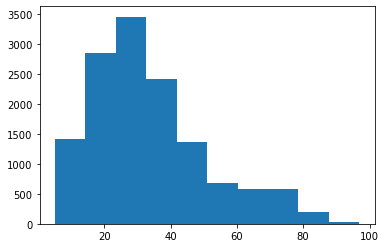

In [721]:
plt.hist(ASO_nAbl_MarApr_total_arr)

In [1031]:
abl_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "fVeg": fVEG_arr,
    "ndAbl_MarApr": ASO_nAbl_MarApr_arr,
    "ndAbl_AprMay": ASO_nAbl_AprMay_arr,
    "nAbl_MarApr": ASO_nAbl_MarApr_total_arr,
    "nAbl_AprMay": ASO_nAbl_AprMay_total_arr
})
nAbl_bins_set = ([0,20,40,60,80,100])
ndAbl_bins_set = ([-20,-10,0,10,20,30,40])

In [1032]:
abl_df['nness_bins'] = pd.cut(abl_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
abl_df['elev_bins'] = pd.cut(abl_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
abl_df['fVeg_bins'] = pd.cut(abl_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)

abl_df['ndAbl_MarApr_bins'] = pd.cut(abl_df['ndAbl_MarApr'], bins=ndAbl_bins_set, right = False,include_lowest= True)
abl_df['ndAbl_AprMay_bins'] = pd.cut(abl_df['ndAbl_AprMay'], bins=ndAbl_bins_set, right = False,include_lowest= True)

abl_df['nAbl_MarApr_bins'] = pd.cut(abl_df['nAbl_MarApr'], bins=nAbl_bins_set, right = False,include_lowest= True)
abl_df['nAbl_AprMay_bins'] = pd.cut(abl_df['nAbl_AprMay'], bins=nAbl_bins_set, right = False,include_lowest= True)

### Filter dataframe
This should no longer be necessary with raw rasters filtered

In [ ]:
# swe_160417_0 = abl_df['swe_160417'] == 0
# abl_df.loc[swe_160417_0, 'abl_MarApr'] = np.nan; abl_df.loc[swe_160417_0, 'delta_abl_MarApr'] = np.nan
# abl_df.loc[swe_160417_0, 'abl_MarMay'] = np.nan; abl_df.loc[swe_160417_0, 'delta_abl_MarMay'] = np.nan

# swe_160518_0 = abl_df['swe_160518'] == 0
# abl_df.loc[swe_160518_0, 'abl_AprMay'] = np.nan; abl_df.loc[swe_160518_0, 'delta_abl_AprMay'] = np.nan
# abl_df.loc[swe_160518_0, 'abl_MarMay'] = np.nan; abl_df.loc[swe_160518_0, 'delta_abl_MarMay'] = np.nan

# abl_MarApr_mask = abl_df['abl_MarApr'] < 5
# abl_AprMay_mask = abl_df['abl_AprMay'] < 5
# abl_MarMay_mask = abl_df['abl_MarMay'] < 5

# abl_df.loc[abl_MarApr_mask, 'abl_MarApr'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_MarApr'] = np.nan
# abl_df.loc[abl_AprMay_mask, 'abl_AprMay'] = np.nan; abl_df.loc[abl_AprMay_mask, 'delta_abl_AprMay'] = np.nan
# abl_df.loc[abl_MarMay_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_MarMay_mask, 'delta_abl_MarMay'] = np.nan

# abl_df.loc[abl_MarApr_mask, 'abl_AprMay'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_AprMay'] = np.nan
# abl_df.loc[abl_MarApr_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_MarApr_mask, 'delta_abl_MarMay'] = np.nan
# abl_df.loc[abl_AprMay_mask, 'abl_MarMay'] = np.nan; abl_df.loc[abl_AprMay_mask, 'delta_abl_MarMay'] = np.nan

In [195]:
# mm/day
# difference between pixel and open area of pixel (absolute)
abl_df['diff_abl_MarApr_mmd'] = (abl_df.abl_MarApr-abl_df.abl_MarApr_open)*10/23
abl_df['diff_abl_AprMay_mmd'] = (abl_df.abl_AprMay-abl_df.abl_AprMay_open)*10/32
abl_df['diff_abl_MarMay_mmd'] = (abl_df.abl_MarMay-abl_df.abl_MarMay_open)*10/54


In [196]:
abl_MarMay_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])
abl_MarApr_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])
abl_AprMay_bins_set = ([0,10,20,30,40,50,60,70,80,90,100,110,120])

abl_df['abl_MarApr_bins'] = pd.cut(abl_df['abl_MarApr'], bins=abl_MarMay_bins_set, right = False,include_lowest= True)
abl_df['abl_MarMay_bins'] = pd.cut(abl_df['abl_MarMay'], bins=abl_MarApr_bins_set, right = False,include_lowest= True)
abl_df['abl_AprMay_bins'] = pd.cut(abl_df['abl_AprMay'], bins=abl_AprMay_bins_set, right = False,include_lowest= True)

# Plot

## Hist

In [92]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'DNC', 'clump', 'swe_160326', 'swe_080210',
       'delta_acc_ASO', 'delta_acc_NCALM', 'nness_bins', 'elev_bins',
       'fVeg_bins', 'DNC_bins', 'clump_bins'],
      dtype='object')

In [ ]:
# plot elevation vs. snow depth and fsca (mean)
terrain_hist, axs = plt.subplots(2, 2, figsize =(15,4));
axs[0,0].hist(acc_df['swe_160326']); axs[0,0].set_xlabel('SWE 03/26/2016 (cm)')
axs[0,1].hist(acc_df['swe_080210']); axs[0,1].set_xlabel('SWE 02/10/2008 (cm)')
#axs[1,0].hist(acc_df['delta_acc_ASO']); axs[1,0].set_xlabel('delta_SWE 03/26/2016 (cm)')
#axs[1,1].hist(acc_df['delta_acc_NCALM']); axs[1,1].set_xlabel('delta_SWE 02/10/2008 (cm)')
#terrain_hist.savefig('lidar_processing/python_scripts/snow_departure_project/figures/terrain_variable_histogram.png')

In [ ]:
# import matplotlib.ticker as mticker
# SWE_nness_elevBins_scatter, axes = plt.subplots(2,3,figsize=(25, 15), sharey=False, sharex=False) # create a figure axis
# #nness_deltaFSCA_group_box.suptitle('orthness vs. Change in fSCA') # add title to entire figure
# #palette_arr = ['darkorange','lightyellow','lightblue','royalblue']
# for i in range(3):
#     sns.scatterplot(ax=axes[0,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i]]))
#     axes[0,i].set(xticklabels = [],title = ('Elevation = ' + str(elev_bins_arr_sort[i])), xlabel = '',ylabel = 'SWE (cm) 03/26/2016')

#     sns.scatterplot(ax=axes[1,i], y = (acc_df['swe_160326'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]), x = (acc_df['nness'][acc_df['elev_bins'] == elev_bins_arr_sort[i+3]]))
#     axes[1,i].set(title = ('Elevation = ' + str(elev_bins_arr_sort[i+3])), xlabel = 'Northness',ylabel = 'SWE (cm) 03/26/2016')
#     #axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
#     # ticks_loc = axes[1,i].get_xticks().tolist()
#     # axes[1,i].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     # axes[1,i].set_xticklabels(axes[1,i].get_xticklabels(),rotation = 30, size = 10)
# SWE_nness_elevBins_scatter.savefig('SCB/stats/figures/SWE_nness_elevBins_scatter.png')

In [796]:
acc_df['SWE_2008_open'] = NCALM_2008_open_arr
acc_df['diff_2008'] = acc_df.SWE_2008 - acc_df.SWE_2008_open

(array([ 1362.,  7442., 14822., 21925.,  9377.,  6531.,  3102.,  2102.,
         1769.,   419.]),
 array([1816.65      , 1901.99803846, 1987.34607692, 2072.69411538,
        2158.04215385, 2243.39019231, 2328.73823077, 2414.08626923,
        2499.43430769, 2584.78234615, 2670.13038462]),
 <BarContainer object of 10 artists>)

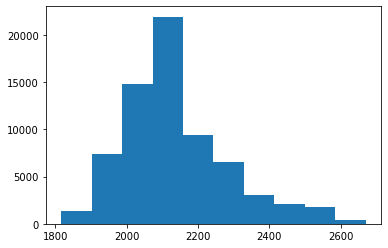

In [49]:
plt.hist(acc_df.elev)

<AxesSubplot:xlabel='SWE_2008', ylabel='diff_2008'>

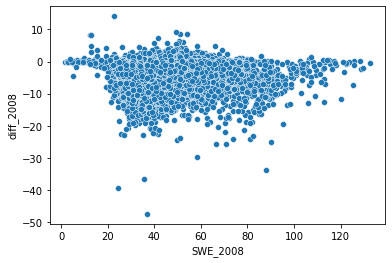

In [797]:

sns.scatterplot(data=acc_df, x="SWE_2008", y="diff_2008")

## Accumulation

In [1012]:
acc_df.columns

Index(['elev', 'nness', 'fVeg', 'fVeg_2020', 'openness', 'canopy_den', 'LAI',
       'delta_SWE_2008_abs', 'SWE_2008_open', 'SWE_2016', 'SWE_2008',
       'SWE_2022', 'delta_SWE_2016', 'delta_SWE_2008', 'delta_SWE_2022',
       'elev_bins', 'fVeg_bins', 'fVeg_2020_bins', 'nness_bins',
       'delta_SWE_2016_bins', 'delta_SWE_2008_bins', 'SWE_2016_bins',
       'SWE_2008_bins'],
      dtype='object')

**Absolute**

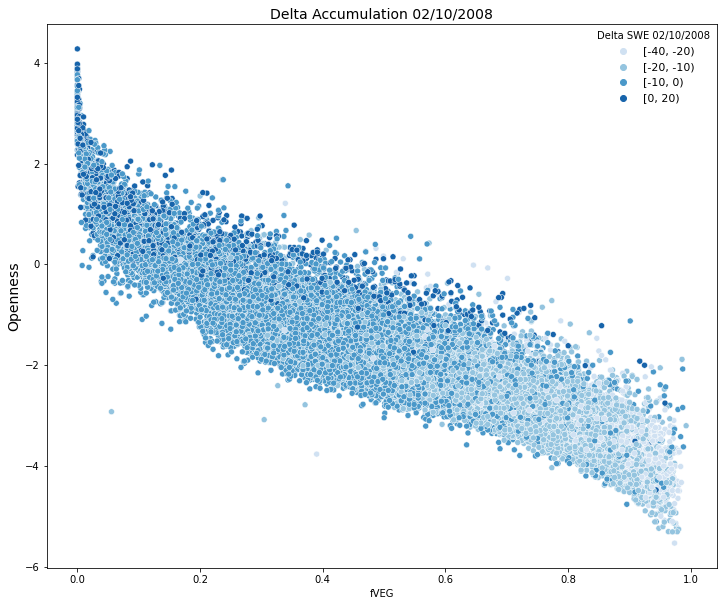

In [46]:
elev_nness_fveg_fig, axes = plt.subplots(1,figsize=(12, 10), sharey=False) # create a figure axis
sns.scatterplot(ax=axes, data=acc_df, x='fVeg', y="openness", hue ='delta_SWE_2008_bins', palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Delta Accumulation 02/10/2008', fontsize = 14); axes.set_xlabel('fVEG'); axes.set_ylabel('Openness', fontsize = 14)
#axes.set_xticklabels([])
axes.legend( loc='upper right', borderaxespad=0.2, title= 'Delta SWE 02/10/2008', fontsize=11, frameon=False)
#axes[0].text(-0.40, 1.12,"a", ha="left", va="top", size=12, color='black', weight='normal')

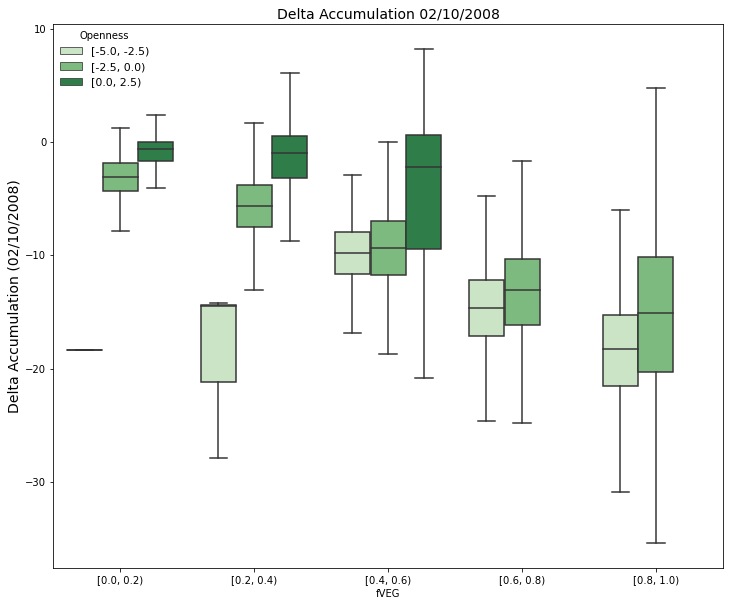

In [48]:
elev_nness_fveg_fig, axes = plt.subplots(1,figsize=(12, 10), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=acc_df, x='fVeg_bins', y="delta_SWE_2008", hue ='openness_bins', showfliers = False, palette = 'Greens') #, hue = 'nness_bins'
axes.set_title('Delta Accumulation 02/10/2008', fontsize = 14); axes.set_xlabel('fVEG'); axes.set_ylabel('Delta Accumulation (02/10/2008)', fontsize = 14)
#axes.set_xticklabels([])
axes.legend( loc='upper left', borderaxespad=0.2, title= 'Openness', fontsize=11, frameon=False)
#axes[0].text(-0.40, 1.12,"a", ha="left", va="top", size=12, color='black', weight='normal')

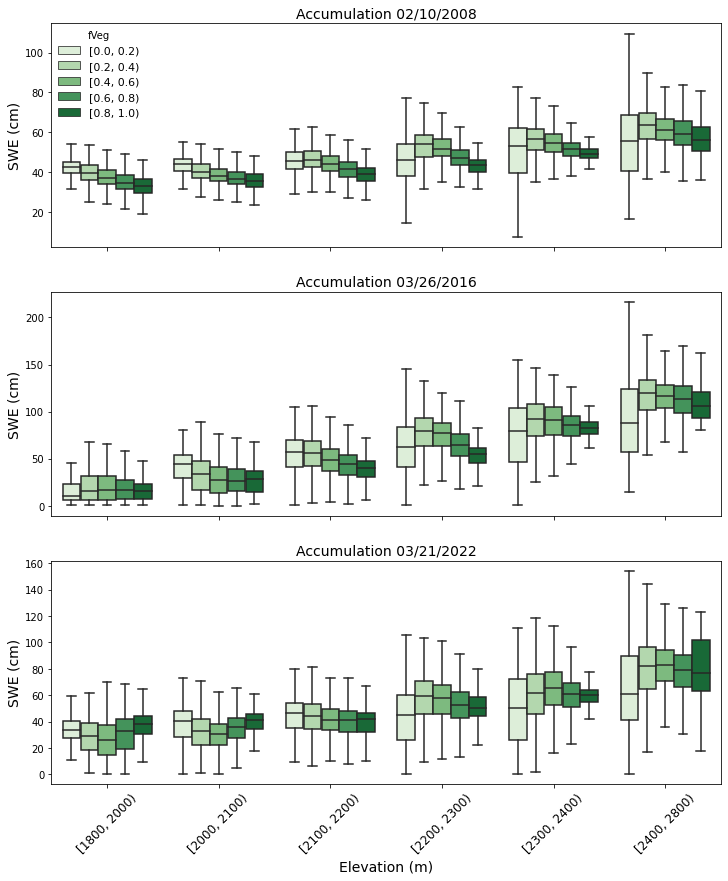

In [1050]:
elev_nness_fveg_fig, axes = plt.subplots(3,1,figsize=(12, 14), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="SWE_2008", hue ='fVeg_bins', showfliers = False, palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('Accumulation 02/10/2008', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('SWE (cm)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend( loc='upper left', borderaxespad=0.2, title= 'fVEG', fontsize=11, frameon=False)
#axes[0].text(-0.40, 1.12,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="SWE_2016", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('Accumulation 03/26/2016', fontsize = 14); axes[1].set_xlabel('', fontsize = 14); axes[1].set_ylabel('SWE (cm)', fontsize = 14)
axes[1].set_xticklabels([])#axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'fVeg', fontsize=12)
#axes[1].text(-0.40, 1.12,"b", ha="left", va="top", size=12, color='black', weight='normal')
sns.boxplot(ax=axes[2], data=acc_df, x='elev_bins', y="SWE_2022", hue = 'fVeg_2020_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[2].set_title('Accumulation 03/21/2022', fontsize = 14); axes[2].set_xlabel('Elevation (m)', fontsize = 14); axes[2].set_ylabel('SWE (cm)', fontsize = 14)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45, fontsize = 12)
axes[2].legend([],frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'fVeg', fontsize=12)
#axes[2].legend( loc='upper left', borderaxespad=0.2, title= 'fVeg', fontsize=11, frameon=False)

elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/SWE_elev_fVeg_comb.png',transparent=True,bbox_inches='tight',dpi=300)

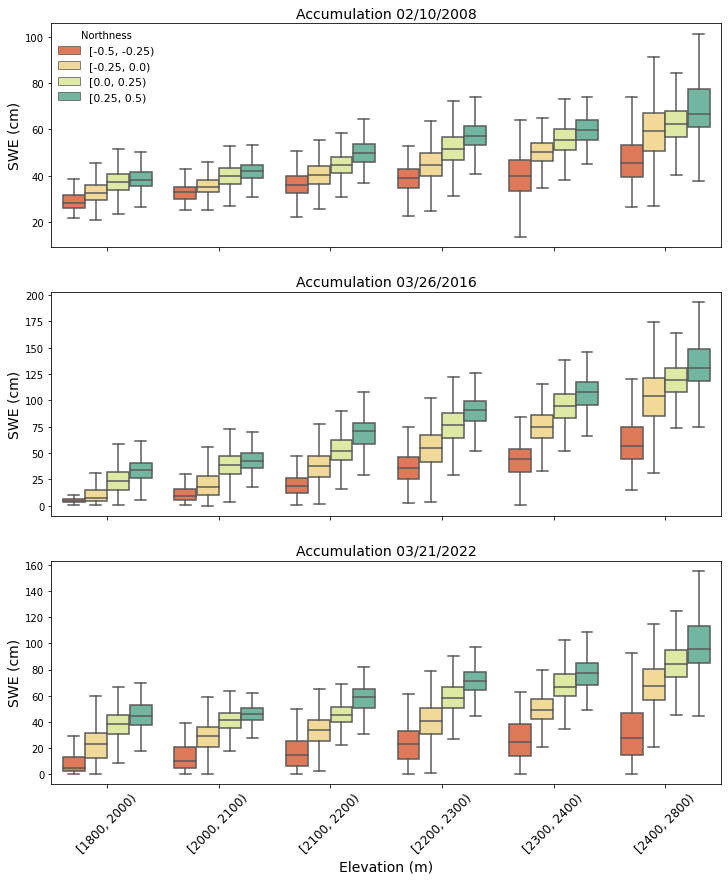

In [1049]:
elev_nness_fveg_fig, axes = plt.subplots(3,1,figsize=(12, 14), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="SWE_2008", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Accumulation 02/10/2008', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('SWE (cm)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend(loc='upper left', borderaxespad=0.2, title= 'Northness', fontsize=11, frameon=False)
#axes[0].text(-0.40, 0.81,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="SWE_2016", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Accumulation 03/26/2016', fontsize = 14); axes[1].set_xlabel('', fontsize = 14); axes[1].set_ylabel('SWE (cm)', fontsize = 14)
axes[1].set_xticklabels([])#axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend([], frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[1].text(-0.40, .75,"b", ha="left", va="top", size=12, color='black', weight='normal')
sns.boxplot(ax=axes[2], data=acc_df, x='elev_bins', y="SWE_2022", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[2].set_title('Accumulation 03/21/2022', fontsize = 14); axes[2].set_xlabel('Elevation (m)', fontsize = 14); axes[2].set_ylabel('SWE (cm)', fontsize = 14)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45, fontsize = 12)
axes[2].legend([], frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=12)
#axes[1].text(-0.40, .75,"b", ha="left", va="top", size=12, color='black', weight='normal')

elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/SWE_elev_nness_comb.png',transparent=True,bbox_inches='tight',dpi=300)

**Delta**

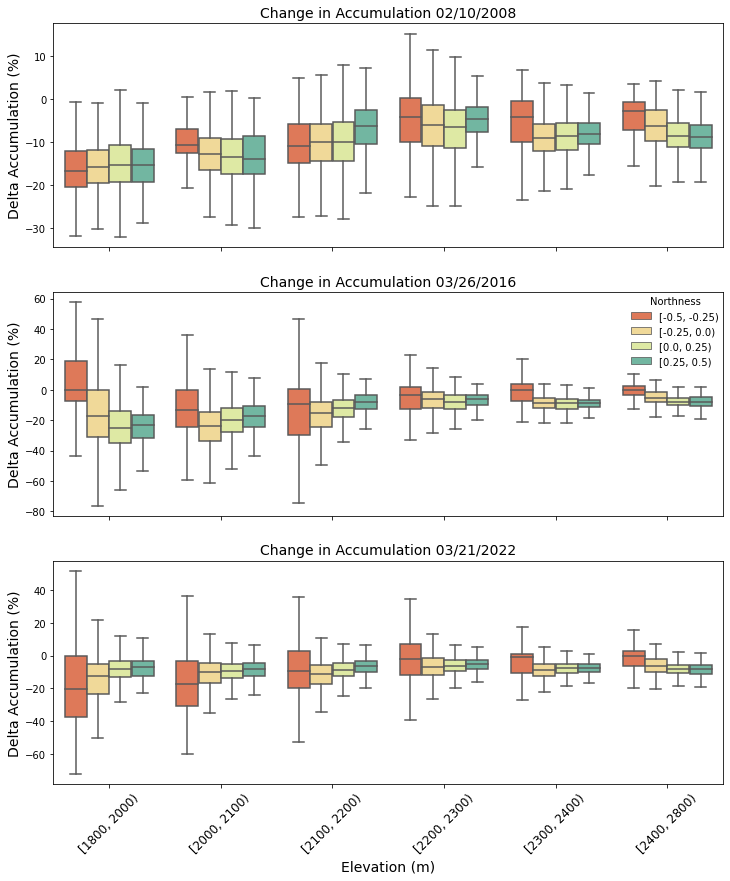

In [1052]:
elev_nness_fveg_fig, axes = plt.subplots(3,1,figsize=(12, 14), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="delta_SWE_2008", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Change in Accumulation 02/10/2008', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend([], frameon=False)#bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Northness', fontsize=11, frameon=False)

#axes[0].text(-0.40, 0.8,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="delta_SWE_2016", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Change in Accumulation 03/26/2016', fontsize = 14); axes[1].set_xlabel('', fontsize = 14); axes[1].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[1].set_xticklabels([])#axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend(loc='upper right', borderaxespad=0, title= 'Northness', fontsize=10, frameon=False)
#axes[1].text(-0.40, 0.75,"b", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[2], data=acc_df, x='elev_bins', y="delta_SWE_2022", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[2].set_title('Change in Accumulation 03/21/2022', fontsize = 14); axes[2].set_xlabel('Elevation (m)', fontsize = 14); axes[2].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45, fontsize = 12)
axes[2].legend([],frameon=False)#loc='upper right', borderaxespad=0, title= 'Northness', fontsize=11, frameon=False)

elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/deltaAcc_terrain_comb.png',transparent=True,bbox_inches='tight',dpi=300)

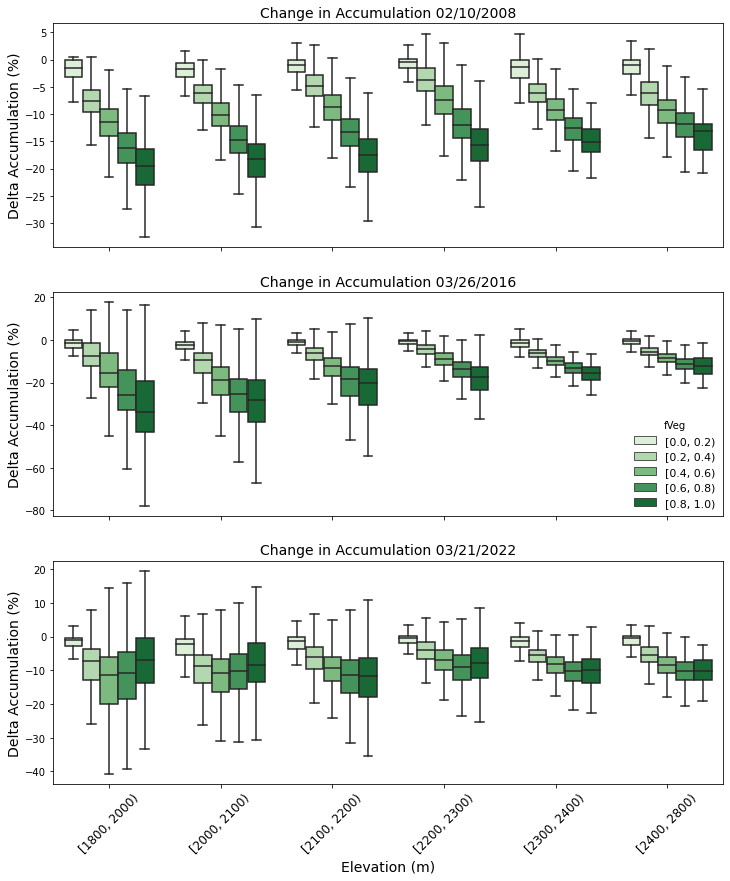

In [1057]:
elev_nness_fveg_fig, axes = plt.subplots(3,1,figsize=(12, 14), sharey=False) # create a figure axis
sns.boxplot(ax=axes[0], data=acc_df, x='elev_bins', y="delta_SWE_2008", hue = 'fVeg_bins', showfliers = False, palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('Change in Accumulation 02/10/2008', fontsize = 14); axes[0].set_xlabel(''); axes[0].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[0].set_xticklabels([])
axes[0].legend([],frameon=False)#,bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'fVeg', fontsize=10)
#axes[0].text(-0.40, 1.12,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=acc_df, x='elev_bins', y="delta_SWE_2016", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('Change in Accumulation 03/26/2016', fontsize = 14); axes[1].set_xlabel('', fontsize = 14); axes[1].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[1].set_xticklabels([])#axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
axes[1].legend(loc='lower right', borderaxespad=0.3, title= 'fVeg', fontsize=11, frameon=False)
#axes[1].text(-0.40, 1.12,"b", ha="left", va="top", size=12, color='black', weight='normal')
sns.boxplot(ax=axes[2], data=acc_df, x='elev_bins', y="delta_SWE_2022", hue = 'fVeg_2020_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[2].set_title('Change in Accumulation 03/21/2022', fontsize = 14); axes[2].set_xlabel('Elevation (m)', fontsize = 14); axes[2].set_ylabel('Delta Accumulation (%)', fontsize = 14)
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation = 45, fontsize = 12)
axes[2].legend([],frameon=False)#loc='lower right', borderaxespad=0.3, title= 'fVeg', fontsize=11, frameon=False)

elev_nness_fveg_fig.savefig('SCB/stats/figures/snow_terrain_veg/deltaAcc_elev_fVeg_comb.png',transparent=True,bbox_inches='tight',dpi=300)

In [677]:
# elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
# sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_160326",showfliers = False, hue = 'fVeg_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
# axes.set_title('Total SWE 03/26/2016 (cm)', fontsize = 20)
# axes.set_ylabel('SWE', fontsize = 16)
# axes.set_xlabel('Elevation', fontsize = 16)


In [678]:
# elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
# sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_080210",showfliers = False, hue = 'fVeg_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
# axes.set_title('Total SWE 02/10/2008 (cm)', fontsize = 20)
# axes.set_ylabel('SWE', fontsize = 16)
# axes.set_xlabel('Elevation', fontsize = 16)


In [679]:
# elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
# sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_160326",showfliers = False, hue = 'nness_bins', palette="Spectral")#,palette = 'Blues') #, hue = 'nness_bins'
# axes.set_title('Total SWE 03/26/2016 (cm)', fontsize = 20)
# axes.set_ylabel('SWE', fontsize = 16)
# axes.set_xlabel('Elevation', fontsize = 16)

In [680]:
# elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
# sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_080210",showfliers = False, hue = 'nness_bins', palette="Spectral")#,palette = 'Blues') #, hue = 'nness_bins'
# axes.set_title('Total SWE 02/10/2008 (cm)', fontsize = 20)
# axes.set_ylabel('SWE', fontsize = 16)
# axes.set_xlabel('Elevation', fontsize = 16)

In [681]:
# fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="delta_acc_tall_ASO", hue='swe_160326',palette='Blues') #, hue = 'nness_bins'
# axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
# axes.set_xlabel('Fraction of Canopy', fontsize = 16)
# axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
# axes.set(ylim=(-60, 40))

# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

# #fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

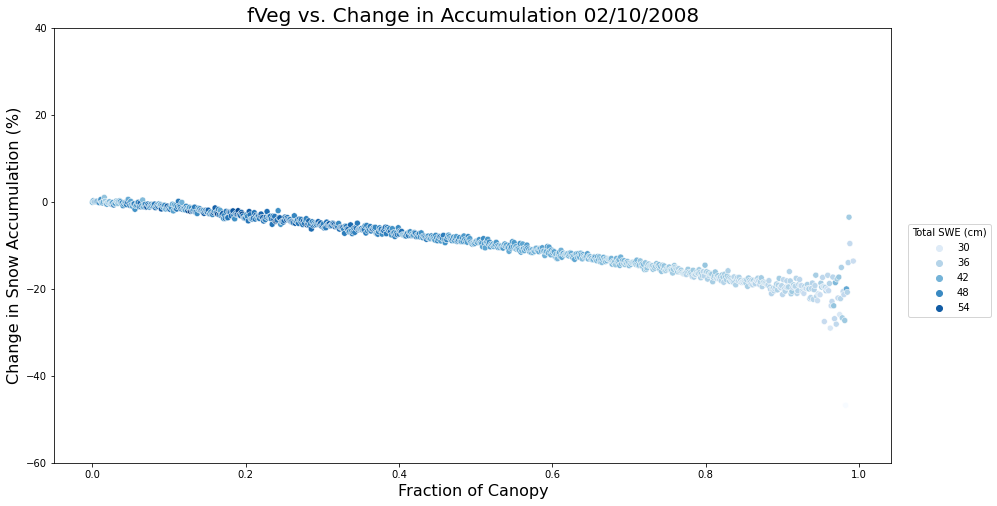

In [682]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="delta_acc_NCALM", hue='swe_080210',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

Text(0, 0.5, 'Total SWE (cm)')

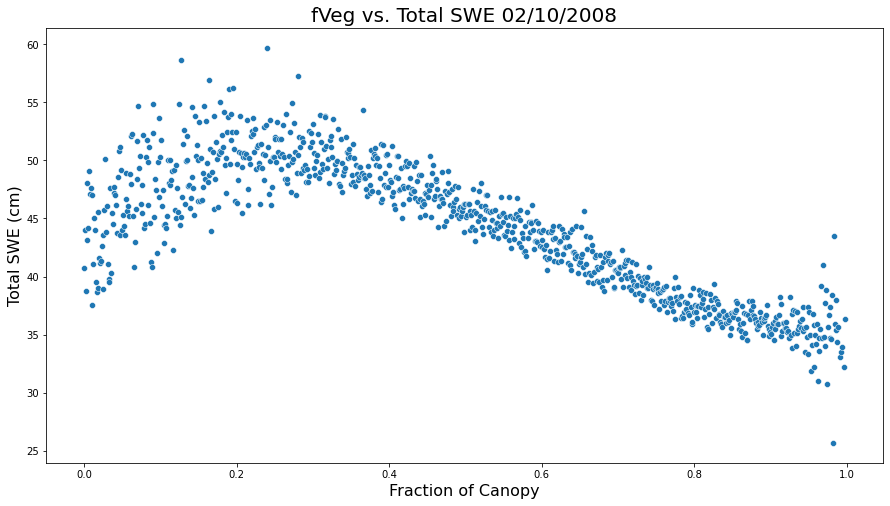

In [683]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=fVeg_avg_df, x='fVeg', y="swe_080210", palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Total SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Fraction of Canopy', fontsize = 16)
axes.set_ylabel('Total SWE (cm)', fontsize = 16)
#axes.set(ylim=(-60, 40))

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_NCALM_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

**better scatterplots in R**

## Ablation

In [514]:
abl_df.columns

Index(['elev', 'nness', 'fVeg', 'nAbl_MarApr', 'nAbl_AprMay', 'nness_bins',
       'elev_bins', 'fVeg_bins', 'MarApr_bins', 'AprMay_bins'],
      dtype='object')

In [ ]:
# plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_AprMay", hue = 'abl_AprMay', palette='Blues') #, hue = 'nness_bins'
# axes.set_title('fVeg vs. Change in Ablation from April to May 2016', fontsize = 20)
# axes.set_xlabel('Fraction of Canopy', fontsize = 16)
# axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
# axes.set(ylim=(-120, 100),xlim=(0,1))

# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

# #plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_AprMay_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
# plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(ax=axes, data=abl_df, x='fVeg', y="delta_abl_MarApr", hue = 'abl_MarApr', palette='Blues') #, hue = 'nness_bins'
# axes.set_title('fVeg vs. Change in Ablation from March to April 2016', fontsize = 20)
# axes.set_xlabel('Fraction of Canopy', fontsize = 16)
# axes.set_ylabel('Change in Snow Ablation (%)', fontsize = 16)
# axes.set(ylim=(-120, 120),xlim=(0,1))

# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
# plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total Ablation (cm)');

# #plot_fig.savefig('SCB/stats/figures/fVeg_ASO_delta_abl_MarApr_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

### Box

In [746]:
abl_df.columns

Index(['elev', 'nness', 'fVeg', 'ndAbl_MarApr', 'ndAbl_AprMay', 'nAbl_MarApr',
       'nAbl_AprMay', 'nness_bins', 'elev_bins', 'fVeg_bins',
       'ndAbl_MarApr_bins', 'ndAbl_AprMay_bins', 'nAbl_MarApr_bins',
       'nAbl_AprMay_bins', 'elev_bins_b', 'elev_bins_c'],
      dtype='object')

In [1038]:
# create new elevation bins to split x axis for ear/late season ablation 

#abl_df_filtered_early = abl_df[abl_df.elev<2200]
#abl_df.elev_bins
elev_bins_set_b = ([2000,2050,2100, 2150, 2200])
abl_df['elev_bins_b'] = pd.cut(abl_df['elev'], bins=elev_bins_set_b, right = False,include_lowest= True)
elev_bins_set_c = ([2200,2250,2300,2350,2400, 2450, 2500])
abl_df['elev_bins_c'] = pd.cut(abl_df['elev'], bins=elev_bins_set_c, right = False,include_lowest= True)

**normalized**

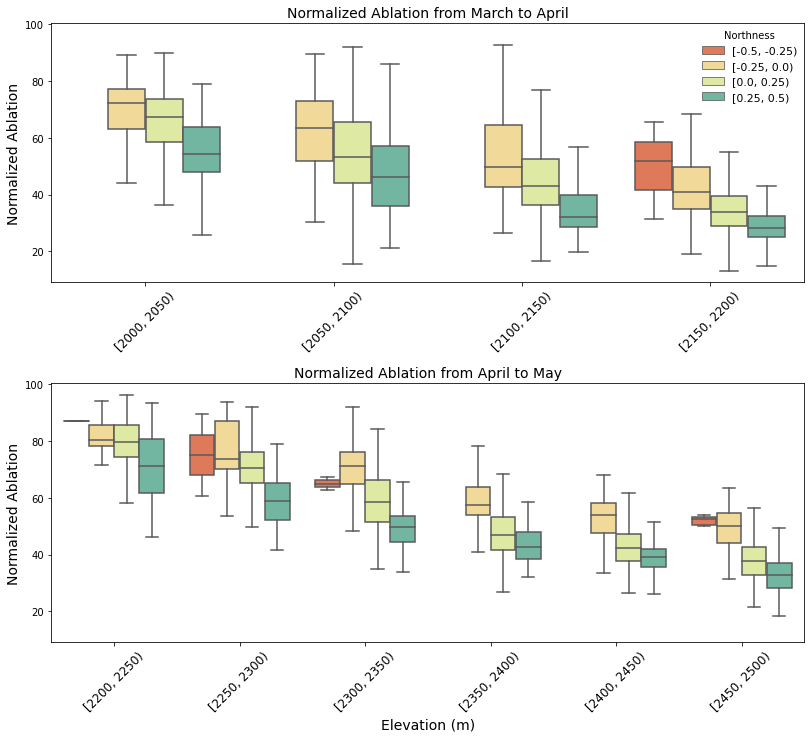

In [1058]:
abl_box, axes = plt.subplots(2,1,figsize=(12, 10), sharey=True) # create a figure axis
plt.tight_layout(pad = 4, h_pad = 8)
sns.boxplot(ax=axes[0], data=abl_df, x='elev_bins_b', y="nAbl_MarApr", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Normalized Ablation from March to April', fontsize = 14); axes[0].set_xlabel('', fontsize = 14); axes[0].set_ylabel('Normalized Ablation', fontsize = 14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45, fontsize = 12)
axes[0].legend(loc='upper right', borderaxespad=.2, title= 'Northness', fontsize=11,frameon=False)
#axes[0].text(-0.44, 0.67,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=abl_df, x='elev_bins_c', y="nAbl_AprMay", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Normalized Ablation from April to May', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('Normalized Ablation', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
#axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Ablation (%)', fontsize=12)
axes[1].legend([], frameon=False)
#axes[1].text(-0.42, 0.67,"b", ha="left", va="top", size=12, color='black', weight='normal')

abl_box.savefig('SCB/stats/figures/snow_terrain_veg/nAbl_terrain.png',transparent=True,bbox_inches='tight',dpi=300)

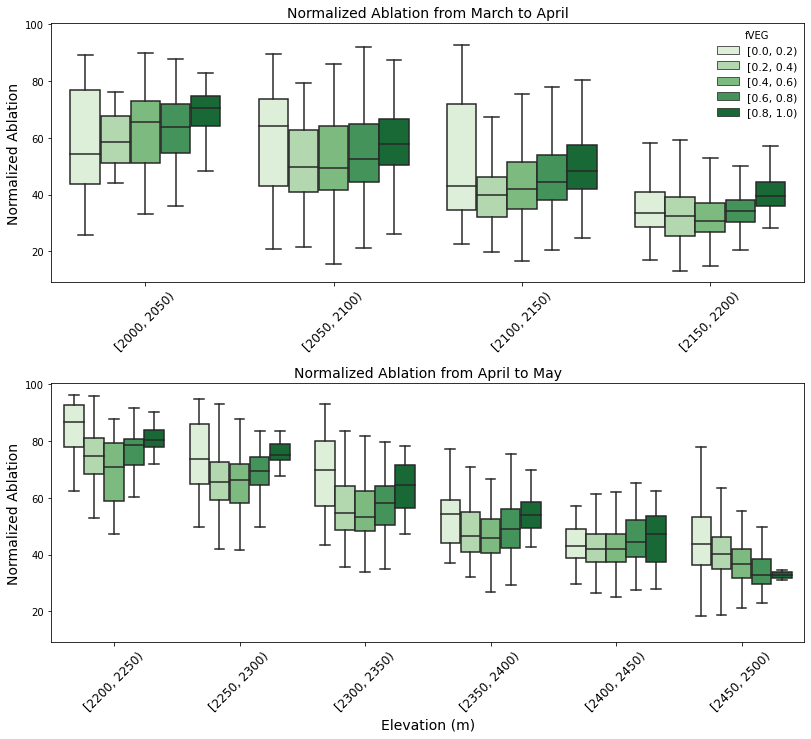

In [1059]:
abl_box, axes = plt.subplots(2,1,figsize=(12, 10), sharey=True) # create a figure axis
plt.tight_layout(pad = 4, h_pad = 8)

sns.boxplot(ax=axes[0], data=abl_df, x='elev_bins_b', y="nAbl_MarApr", hue = 'fVeg_bins', showfliers = False, palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('Normalized Ablation from March to April', fontsize = 14); axes[0].set_xlabel('', fontsize = 14); axes[0].set_ylabel('Normalized Ablation', fontsize = 14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45, fontsize = 12)
axes[0].legend(loc='upper right', borderaxespad=0.2, title= 'fVEG', fontsize=11, frameon=False)
#axes[0].text(-0.44, 0.67,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=abl_df, x='elev_bins_c', y="nAbl_AprMay", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('Normalized Ablation from April to May', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('Normalized Ablation', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
#axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Ablation (%)', fontsize=12)
axes[1].legend([], frameon=False)
#axes[1].text(-0.42, 0.67,"b", ha="left", va="top", size=12, color='black', weight='normal')

abl_box.savefig('SCB/stats/figures/snow_terrain_veg/nAbl_elev_fVeg.png',transparent=True,bbox_inches='tight',dpi=300)

**normalized difference**

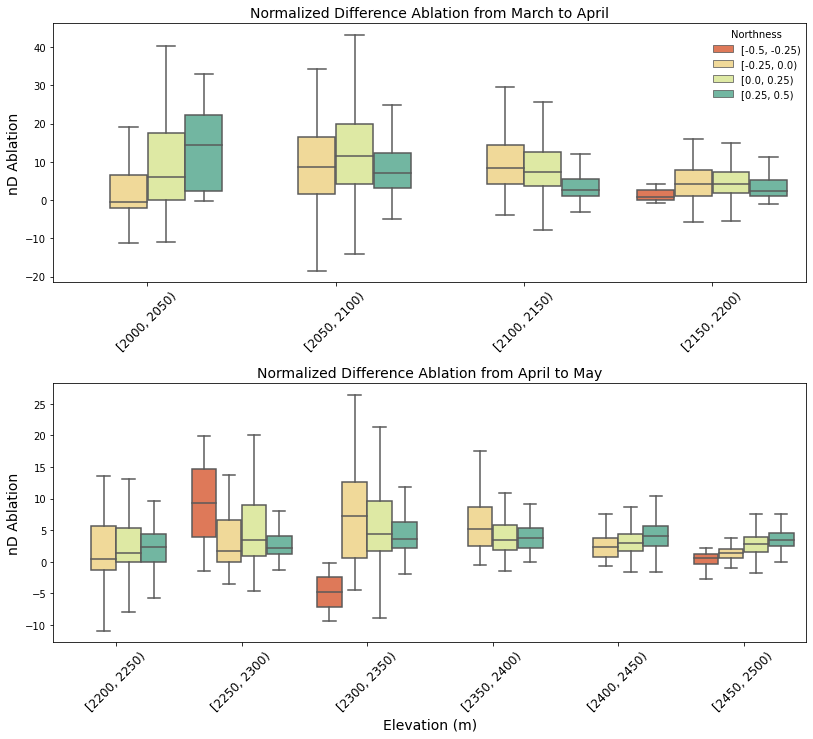

In [1060]:
abl_box, axes = plt.subplots(2,1,figsize=(12, 10), sharey=False) # create a figure axis
plt.tight_layout(pad = 4, h_pad = 8)
sns.boxplot(ax=axes[0], data=abl_df, x='elev_bins_b', y="ndAbl_MarApr", hue = 'nness_bins', showfliers = False, palette = 'Spectral') #, hue = 'nness_bins'
axes[0].set_title('Normalized Difference Ablation from March to April', fontsize = 14); axes[0].set_xlabel('', fontsize = 14); axes[0].set_ylabel('nD Ablation', fontsize = 14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45, fontsize = 12)
axes[0].legend(loc='upper right', borderaxespad=.2, title= 'Northness', fontsize=10, frameon=False)
#axes[0].text(-0.44, 0.67,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=abl_df, x='elev_bins_c', y="ndAbl_AprMay", hue = 'nness_bins', showfliers = False,palette = 'Spectral') #, hue = 'nness_bins'
axes[1].set_title('Normalized Difference Ablation from April to May', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('nD Ablation', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
#axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Ablation (%)', fontsize=12)
axes[1].legend([], frameon=False)
#axes[1].text(-0.42, 0.67,"b", ha="left", va="top", size=12, color='black', weight='normal')

abl_box.savefig('SCB/stats/figures/snow_terrain_veg/ndAbl_terrain.png',transparent=True,bbox_inches='tight',dpi=300)

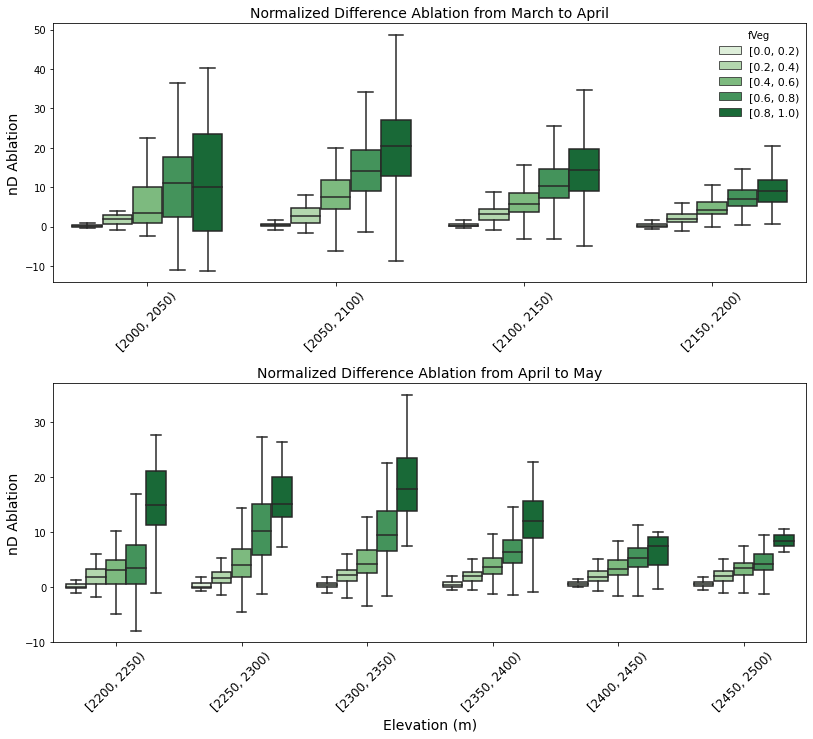

In [1061]:
abl_box, axes = plt.subplots(2,1,figsize=(12, 10), sharey=False) # create a figure axis
plt.tight_layout(pad = 4, h_pad = 8)

sns.boxplot(ax=axes[0], data=abl_df, x='elev_bins_b', y="ndAbl_MarApr", hue = 'fVeg_bins', showfliers = False, palette = 'Greens') #, hue = 'nness_bins'
axes[0].set_title('Normalized Difference Ablation from March to April', fontsize = 14); axes[0].set_xlabel('', fontsize = 14); axes[0].set_ylabel('nD Ablation', fontsize = 14)
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation = 45, fontsize = 12)
axes[0].legend(loc='upper right', borderaxespad=0.2, title= 'fVeg', fontsize=11, frameon=False)
#axes[0].text(-0.44, 0.67,"a", ha="left", va="top", size=12, color='black', weight='normal')

sns.boxplot(ax=axes[1], data=abl_df, x='elev_bins_c', y="ndAbl_AprMay", hue = 'fVeg_bins', showfliers = False,palette = 'Greens') #, hue = 'nness_bins'
axes[1].set_title('Normalized Difference Ablation from April to May', fontsize = 14); axes[1].set_xlabel('Elevation (m)', fontsize = 14); axes[1].set_ylabel('nD Ablation', fontsize = 14)
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation = 45, fontsize = 12)
#axes[1].legend(bbox_to_anchor=(1.02, 0.80), loc='upper left', borderaxespad=0, title= 'Ablation (%)', fontsize=12)
axes[1].legend([],frameon=False)
#axes[1].text(-0.42, 0.67,"b", ha="left", va="top", size=12, color='black', weight='normal')

abl_box.savefig('SCB/stats/figures/snow_terrain_veg/ndAbl_elev_fVeg.png',transparent=True,bbox_inches='tight',dpi=300)

Text(0.5, 0, 'Elevation')

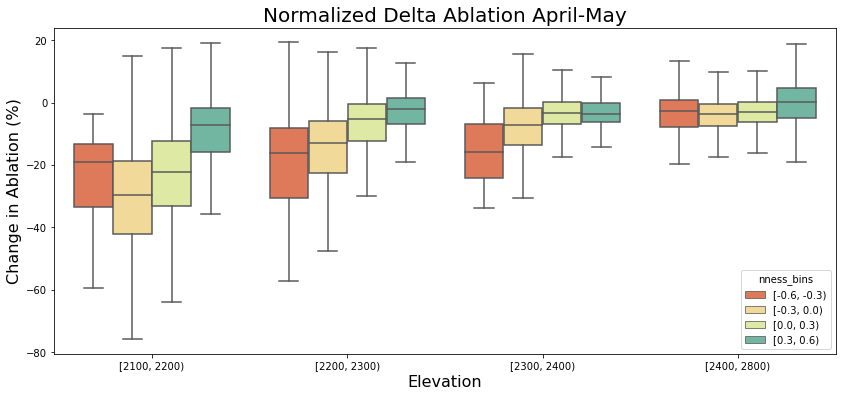

In [243]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=abl_df_filtered_late, x='elev_bins_b', y="delta_abl_AprMay",showfliers = False, hue = 'nness_bins', palette="Spectral")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Normalized Delta Ablation April-May', fontsize = 20)
axes.set_ylabel('Change in Ablation (%)', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)

In [186]:
abl_df.columns

Index(['elev', 'nness', 'fVeg', 'DNC', 'swe_160326', 'swe_160417',
       'swe_160518', 'abl_MarApr', 'abl_MarMay', 'abl_AprMay',
       'abl_MarApr_open', 'abl_MarMay_open', 'abl_AprMay_open',
       'delta_abl_MarApr', 'delta_abl_MarMay', 'delta_abl_AprMay',
       'nness_bins', 'elev_bins', 'fVeg_bins', 'diff_abl_MarApr_mmd',
       'diff_abl_AprMay_mmd', 'diff_abl_MarMay_mmd', 'abl_MarApr_bins',
       'abl_MarMay_bins', 'abl_AprMay_bins'],
      dtype='object')

Text(0.5, 0, 'Elevation')

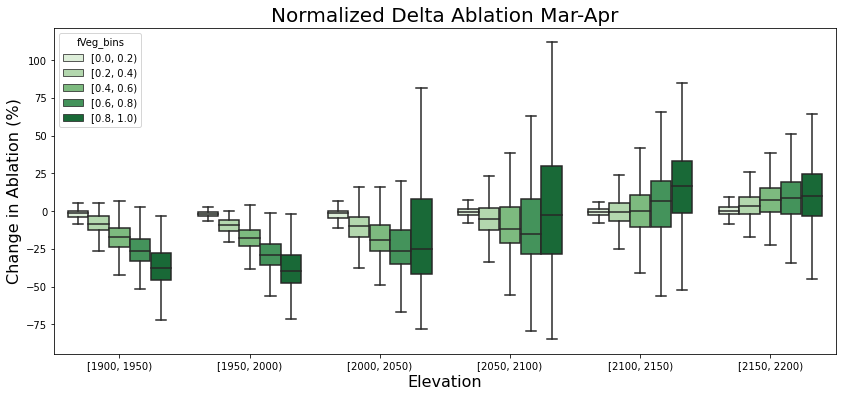

In [251]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=abl_df_filtered_early, x='elev_bins_c', y="delta_abl_MarApr",showfliers = False, hue = 'fVeg_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Normalized Delta Ablation Mar-Apr', fontsize = 20)
axes.set_ylabel('Change in Ablation (%)', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)


Text(0.5, 0, 'Elevation')

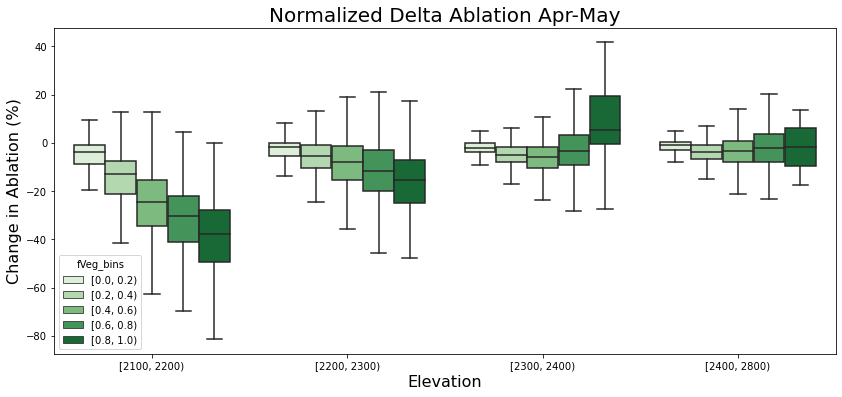

In [253]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(14, 6), sharey=False) # create a figure axis
sns.boxplot(ax=axes, data=abl_df_filtered_late, x='elev_bins_b', y="delta_abl_AprMay",showfliers = False, hue = 'fVeg_bins', palette="Greens")#,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Normalized Delta Ablation Apr-May', fontsize = 20)
axes.set_ylabel('Change in Ablation (%)', fontsize = 16)
axes.set_xlabel('Elevation', fontsize = 16)


In [126]:
# plot_fig, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.boxplot(ax=axes, data=abl_df, x='fVeg_bins', y="abl_MarMay_mmd" ,showfliers = False) #, hue = 'nness_bins'
# axes.set_title('fVeg vs. Ablation from March to May 2016', fontsize = 20)
# axes.set_xlabel('Fraction of Canopy', fontsize = 16)
# axes.set_ylabel('Ablation (mm/day)', fontsize = 16)
# axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);


## Terrain

### Terrain vs. Veg

In [ ]:
terrain_veg, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_160326",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

#elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight',dpi=300)

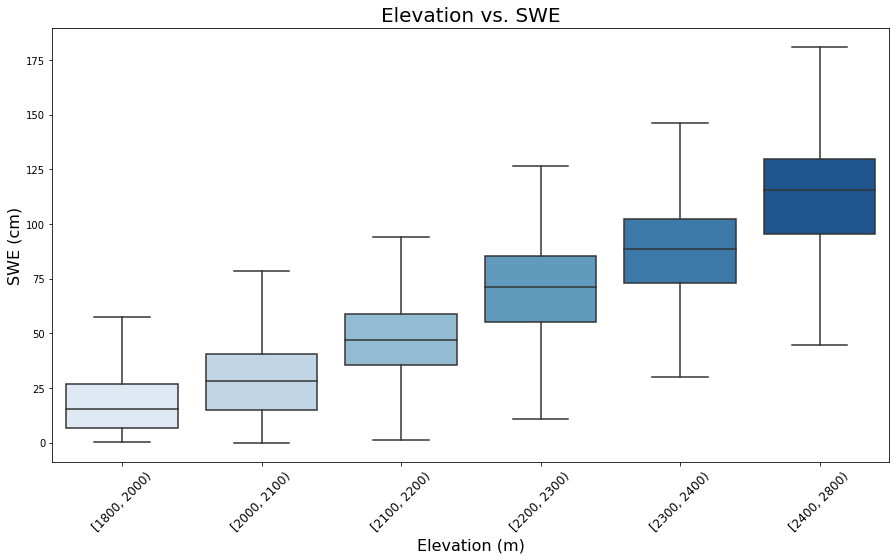

In [178]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='elev_bins', y="swe_160326",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

#elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight',dpi=300)

In [822]:
# elev_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(data=acc_df, x="elev", y="swe_0326", s=20, color=".2", marker=".")
# axes.set_title('Elevation vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
# axes.set_xlabel('Elevation (m)', fontsize = 16)
# axes.set_ylabel('SWE (cm)', fontsize = 16)
# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
# #plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

# #elev_SWE_scatter.savefig('SCB/stats/figures/elev_SWE_0326_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [823]:
# nness_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

# sns.scatterplot(data=acc_df, x="nness", y="swe_0326", s=20, color=".2", marker=".")
# axes.set_title('Northness vs. Sagehen Creek Basin SWE 03/26/2016', fontsize = 20)
# axes.set_xlabel('Northness', fontsize = 16)
# axes.set_ylabel('SWE (cm)', fontsize = 16)
# #axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 16)
# #plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

# #nness_SWE_scatter.savefig('SCB/stats/figures/nness_SWE_0326_scatter.png',transparent=True,bbox_inches='tight',dpi=300)


In [ ]:
elev_bins_arr = acc_df['elev_bins'].unique()
elev_bins_arr_sort = [elev_bins_arr.categories[0],elev_bins_arr.categories[1], elev_bins_arr.categories[2],elev_bins_arr.categories[3],elev_bins_arr.categories[4],elev_bins_arr.categories[5]] # create a new list with sorted values

In [ ]:
acc_df.columns

In [ ]:
elev_SWE_box, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.boxplot(ax=axes, data=acc_df, x='fVeg_bins', y="delta_acc_ASO",showfliers = False,palette = 'Blues') #, hue = 'nness_bins'
axes.set_title('Elevation vs. SWE', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
#plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Gap Size (m)');

elev_SWE_box.savefig('SCB/stats/figures/elev_SWE_0326_box.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
acc_df.columns

### line

In [116]:
acc_df['elev_rnd'] = (round(acc_df.elev/100))*100

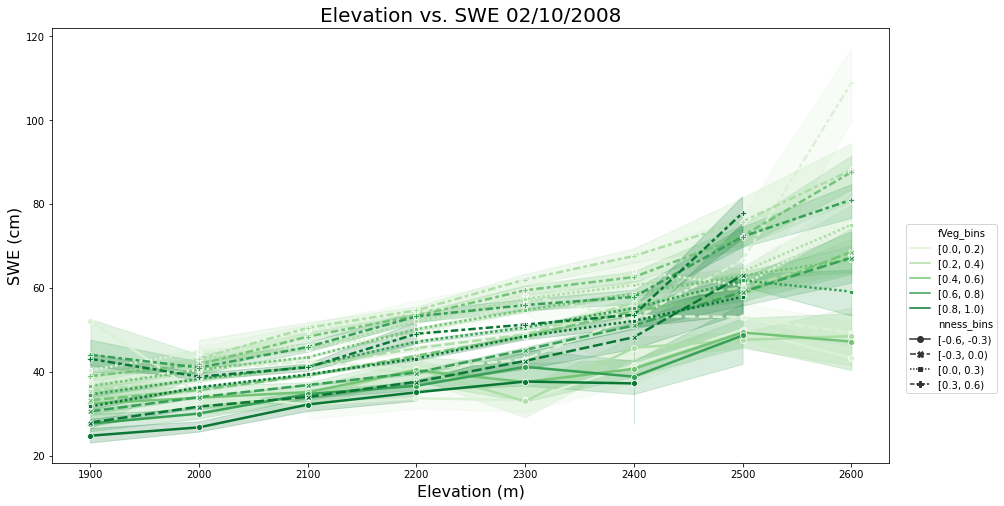

In [125]:
elev_SWE_line, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.lineplot(x=acc_df['elev_rnd'],y=acc_df['swe_080210'], hue=acc_df["fVeg_bins"], style =acc_df["nness_bins"],linewidth=2.5,markers=True, palette='Greens')#,style =acc_df["fVeg_bins"]
axes.set_title('Elevation vs. SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);

#elev_SWE_line.savefig('SCB/stats/figures/elev_SWE_line_08_huenness.png',transparent=True,bbox_inches='tight',dpi=300)

In [160]:
[3,0,1,2]

[3, 0, 1, 2]

In [164]:
acc_df['nness_bins'].unique()

[[-0.3, 0.0), [0.0, 0.3), [0.3, 0.6), [-0.6, -0.3), NaN]
Categories (4, interval[float64, left]): [[-0.6, -0.3) < [-0.3, 0.0) < [0.0, 0.3) < [0.3, 0.6)]

Text(0.5, 0.04, 'Elevation (m)')

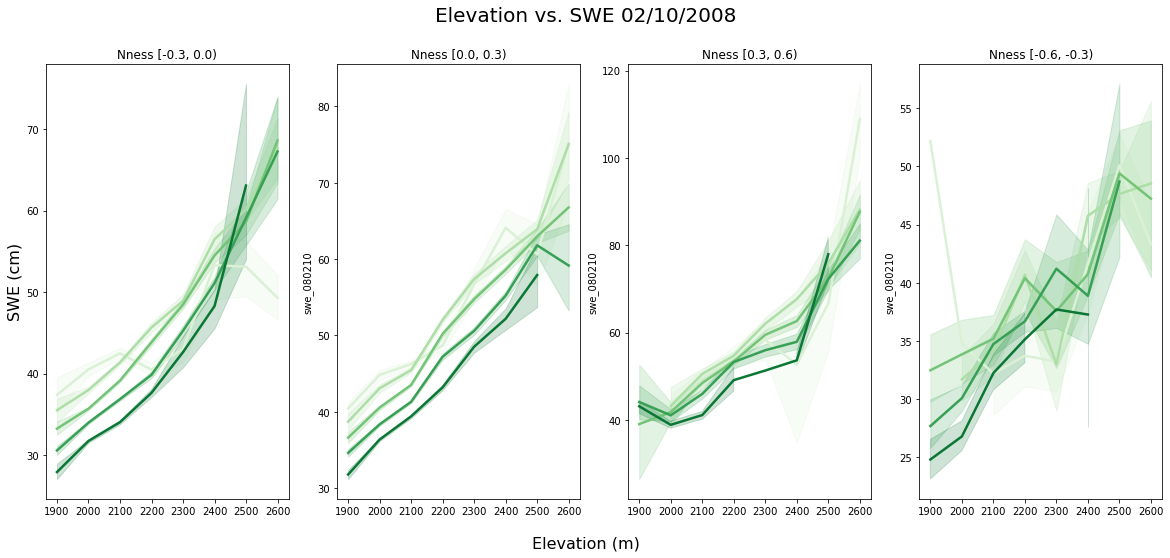

In [161]:
elev_SWE_line, axes = plt.subplots(1,4,figsize=(20, 8), sharey=False) # create a figure axis
elev_SWE_line.suptitle('Elevation vs. SWE 02/10/2008', fontsize = 20) # add title to entire figure


for i in [3,0,1,2]:
    new_df = acc_df[acc_df['nness_bins'] == acc_df['nness_bins'].unique()[i]]
#     axes[0,i].set(xticklabels = [],title = ('Elevation = ' + str(elev_bins_arr_sort[i])), xlabel = '',ylabel = 'SWE (cm) 03/26/2016')
    sns.lineplot(ax=axes[i], x=new_df['elev_rnd'], y=new_df['swe_080210'], hue=new_df["fVeg_bins"], linewidth=2.5, markers=True, palette='Greens', legend=False)#,style =acc_df["fVeg_bins"]
    axes[i].set_title('Nness '+ str(acc_df['nness_bins'].unique()[i]), fontsize = 12)
    axes[i].set_xlabel('')
axes[0].set_ylabel('SWE (cm)', fontsize = 16)
elev_SWE_line.text(0.5, 0.04, 'Elevation (m)', ha='center',fontsize = 16)


<AxesSubplot:xlabel='elev_rnd', ylabel='swe_080210'>

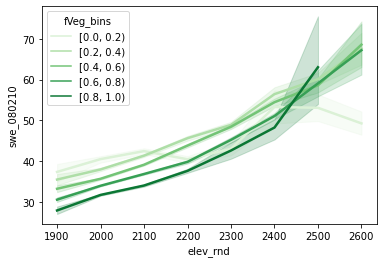

In [146]:
new_df = acc_df[acc_df['nness_bins'] == acc_df['nness_bins'].unique()[0]]
#     axes[0,i].set(xticklabels = [],title = ('Elevation = ' + str(elev_bins_arr_sort[i])), xlabel = '',ylabel = 'SWE (cm) 03/26/2016')
sns.lineplot(x=new_df['elev_rnd'], y=new_df['swe_080210'], hue=new_df["fVeg_bins"], linewidth=2.5, markers=True, palette='Greens')


In [144]:
new_df

NameError: name 'new_df' is not defined

In [ ]:


elev_SWE_line, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.lineplot(x=acc_df['elev_rnd'],y=acc_df['swe_080210'], hue=acc_df["nness_bins"],style =acc_df["fVeg_bins"],  linewidth=2.5,markers=True)
axes.set_title('Elevation vs. SWE 02/10/2008', fontsize = 20)
axes.set_xlabel('Elevation (m)', fontsize = 16)
axes.set_ylabel('SWE (cm)', fontsize = 16)
#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);

#elev_SWE_line.savefig('SCB/stats/figures/elev_SWE_line_08_huenness.png',transparent=True,bbox_inches='tight',dpi=300)

# Regressions

In [ ]:
# with sklearn, run single variable regression
# a downside of this approach is that the input dataframe contains unnecessary data. For now, that's okay
# input: dataframe - pandas dataframe with ind and dep variables
# input: var1 & var2 - independent and dependent variable names (str)
# output: regr_model - sklearn LinearRegreassion()
# output: regression_df - dataframe with residual value
def sing_var_regress(dataframe, var1, var2):
    # establish ind. and dep. variables
    regression_df = dataframe[[var1,var2]].dropna(subset=[var1,var2])
    ind_df = regression_df[[var1]]
    dep_df = regression_df[[var2]]
    # run regression model 
    regr_model = linear_model.LinearRegression()
    regr_model.fit(ind_df,dep_df)
    # calculate residuals
    residual_var = dep_df.values - regr_model.predict(ind_df)
    predicted_var = regr_model.predict(ind_df)
    regression_df.insert(len(regression_df.columns), "residual_var", residual_var, True)
    regression_df.insert(len(regression_df.columns), "predicted_var", predicted_var, True)

    return regr_model, regression_df

In [ ]:
acc_df.columns

In [ ]:
abl_df.columns

In [ ]:
regr_model, regression_df = sing_var_regress(abl_df, 'elev', 'abl_AprMay')
print('r-squared: \n',r2_score(regression_df['abl_AprMay'],regr_model.predict(regression_df[['elev']])))

In [ ]:
#sns.scatterplot(data=regression_df, x="elev", y="residual_var")

In [ ]:
acc_df

In [ ]:
regression_df.columns

In [ ]:
# using statsmodel
regression_df = acc_df[["elev","nness","fVeg","DNC","clump", "swe_080210","delta_acc_NCALM"]].dropna(subset=["elev","nness","fVeg","DNC","clump", "swe_080210","delta_acc_NCALM"])
Y = regression_df['delta_acc_NCALM']
X = regression_df[["elev","nness","fVeg","DNC","clump"]]
X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

# Varhola comp test w/ snowpalm

In [ ]:
snowpalm_df

In [ ]:
# load into array
ASO_0326_open_arr = raster_to_array(ASO_0326_open, -9999)
ASO_0326_tall_arr = raster_to_array(ASO_0326_tall, -9999)
ASO_0326_all_arr = raster_to_array(ASO_0326_all, -9999)
ASO_delta_acc_arr = raster_to_array(ASO_delta_acc, -9999)
ASO_delta_acc_tall_arr = raster_to_array(ASO_delta_acc_tall, -9999)


In [ ]:
test_df = pd.DataFrame({
    "elev": DEM_arr,
    "nness": nness_arr,
    "slope": slope_arr,
    "fVeg": fVEG_arr,
    "ASO_0326_open":ASO_0326_open_arr,
    "ASO_0326_tall":ASO_0326_tall_arr,
    "ASO_0326_all":ASO_0326_all_arr,
    "ASO_delta_acc":ASO_delta_acc_arr,
    "ASO_delta_acc_tall":ASO_delta_acc_tall_arr
})
elev_bins_set = ([1800,2000,2100,2200,2300,2400,2800])
nness_bins_set = ([-0.6,-0.3,0,0.3,0.6])
fVEG_bins_set = ([0,0.25,0.5, 0.75, 1.0])
DNC_bins_set = ([0,5,10,15,20])
clump_bins_set = ([0, 0.5, 1, 1.5, 2])


test_df['nness_bins'] = pd.cut(test_df['nness'], bins=nness_bins_set, right = False,include_lowest= True)
test_df['elev_bins'] = pd.cut(test_df['elev'], bins=elev_bins_set, right = False,include_lowest= True)
test_df['fVeg_bins'] = pd.cut(test_df['fVeg'], bins=fVEG_bins_set, right = False,include_lowest= True)
elev_bins_arr = acc_df['elev_bins'].unique()
nness_bins_arr = acc_df['nness_bins'].unique()

In [ ]:
test_df['tall_ref'] = np.nan
for i in range(6):
    for j in range(5):
        tall_all = test_df.ASO_0326_tall[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])]
        tall_avg = np.nanmean(tall_all)
        test_df.tall_ref[(test_df['elev_bins']==elev_bins_arr[i]) & (test_df['nness_bins']==nness_bins_arr[j])] = tall_avg

In [ ]:
test_df['delta_acc_tallRef'] = (test_df['ASO_0326_all'] -  test_df['tall_ref'])/test_df['tall_ref']*100
test_df['fVeg'] = -(1-test_df['fVeg'])*100

In [ ]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)

In [ ]:
test_df['fVeg_avg'] = round(test_df.fVeg,2)

In [ ]:
test_avg_df = test_df.groupby('fVeg_avg').mean()

In [ ]:
fVeg_SWE_scatter, axes = plt.subplots(1,1,figsize=(15, 8), sharey=False) # create a figure axis

sns.scatterplot(ax=axes, data=test_avg_df, x='fVeg', y="delta_acc_tallRef", hue='ASO_0326_all',palette='Blues') #, hue = 'nness_bins'
axes.set_title('fVeg vs. Change in Accumulation 03/26/2016', fontsize = 20)
axes.set_xlabel('Change in Canopy', fontsize = 16)
axes.set_ylabel('Change in Snow Accumulation (%)', fontsize = 16)
#axes.set(ylim=(-60, 40))
sns.lineplot(ax=axes, data=snowpalm_df, x='fVeg', y="delta_acc_2016", color='k') #, hue = 'nness_bins'

#axes.set_xticklabels(axes.get_xticklabels(),rotation = 45, fontsize = 12);
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0, title= 'Total SWE (cm)');

#fVeg_SWE_scatter.savefig('SCB/stats/figures/fVeg_ASO_delta_SWE_scatter.png',transparent=True,bbox_inches='tight',dpi=300)